# 1D Machine Learning Experiments Using 10 and 30 Audio Clips

## Import

In [18]:
import librosa
import numpy as np
import os
import pandas as pd
import soundfile
import sys
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score,accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 

%matplotlib inline

### Note
We define a function that takes a set of features per time frame and stack the mean, so that the data because 1-D.

In [19]:
def feature_to_1d(features):
    result = np.array([])
    mfcc = np.mean(features.T, axis=0)
    result = np.hstack((result, mfcc))
    return result

## Load Data

In [20]:
# MFCC 10 seconds
f = open('IEMOCAP_Data/Data_10_sec/X_train_mfcc', 'rb')
X_train_10_mfcc = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_10_sec/X_test_mfcc', 'rb')
X_test_10_mfcc = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_10_sec/y_train_mfcc', 'rb')
y_train_10_mfcc = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_10_sec/y_test_mfcc', 'rb')
y_test_10_mfcc = joblib.load(f)
f.close()

# MFCC 30 seconds
f = open('IEMOCAP_Data/Data_30_sec/X_train_mfcc', 'rb')
X_train_30_mfcc = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_30_sec/X_test_mfcc', 'rb')
X_test_30_mfcc = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_30_sec/y_train_mfcc', 'rb')
y_train_30_mfcc = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_30_sec/y_test_mfcc', 'rb')
y_test_30_mfcc = joblib.load(f)
f.close()

# Mel 10 seconds
f = open('IEMOCAP_Data/Data_10_sec/X_train_mel', 'rb')
X_train_10_mel = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_10_sec/X_test_mel', 'rb')
X_test_10_mel = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_10_sec/y_train_mel', 'rb')
y_train_10_mel = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_10_sec/y_test_mel', 'rb')
y_test_10_mel = joblib.load(f)
f.close()

# Mel 30 seconds
f = open('IEMOCAP_Data/Data_30_sec/X_train_mel', 'rb')
X_train_30_mel = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_30_sec/X_test_mel', 'rb')
X_test_30_mel = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_30_sec/y_train_mel', 'rb')
y_train_30_mel = joblib.load(f)
f.close()

f = open('IEMOCAP_Data/Data_30_sec/y_test_mel', 'rb')
y_test_30_mel = joblib.load(f)
f.close()

## Find clipped indices

In [21]:
f = open('IEMOCAP_Data/Data_10_sec/X_test_mel', 'rb')
X_test_mel_f = joblib.load(f)
f.close()

In [22]:
f = open('IEMOCAP_Data/Data_10_sec/X_train_mel', 'rb')
X_train_mel_f = joblib.load(f)
f.close()

In [23]:
X_test_mel_f.shape

(900, 128, 313)

In [24]:
clipped_indices = []

for i in range(900):
    for j in range(128):
        for k in range(313):
            if(k == 312 and X_test_mel_f[i][j][k] != 0):
                clipped_indices.append(i)

len(clipped_indices)

5120

In [25]:
x_clipped =np.array(clipped_indices)
x_clipped =np.unique(x_clipped)

x_clipped

array([  5,  32,  37,  48,  69,  77,  80,  86, 107, 112, 116, 141, 145,
       154, 168, 172, 204, 210, 231, 236, 330, 351, 372, 417, 419, 464,
       482, 505, 587, 636, 693, 720, 733, 743, 756, 800, 811, 842, 852,
       897])

In [26]:
x_unclipped = []
for i in range(len(X_test_mel_f)):
    if i not in x_clipped:
        x_unclipped.append(i)
x_unclipped = np.array(x_unclipped)

In [27]:
#x_unclipped

len(x_unclipped)

860

## Examine clipped audio in train set

In [28]:
clipped_indices_train = []

for i in range(900):
    for j in range(128):
        for k in range(313):
            if(k == 312 and X_train_mel_f[i][j][k] != 0):
                clipped_indices_train.append(i)

In [29]:
x_clipped_t =np.array(clipped_indices_train)
x_clipped_t =np.unique(x_clipped_t)

len(x_clipped_t)

32

## Convert to 1-D

In [30]:
X_train_10_mfcc_1d = []
X_test_10_mfcc_1d = []

X_train_30_mfcc_1d = []
X_test_30_mfcc_1d = []

X_train_10_mel_1d = []
X_test_10_mel_1d = []

X_train_30_mel_1d = []
X_test_30_mel_1d = []

In [31]:
for i in range(len(X_train_10_mfcc)):
    X_train_10_mfcc_1d.append(feature_to_1d(X_train_10_mfcc[i]))
for i in range(len(X_test_10_mfcc)):
    X_test_10_mfcc_1d.append(feature_to_1d(X_test_10_mfcc[i]))
for i in range(len(X_train_30_mfcc)):
    X_train_30_mfcc_1d.append(feature_to_1d(X_train_30_mfcc[i]))
for i in range(len(X_test_30_mfcc)):
    X_test_30_mfcc_1d.append(feature_to_1d(X_test_30_mfcc[i]))
    
for i in range(len(X_train_10_mel)):
    X_train_10_mel_1d.append(feature_to_1d(X_train_10_mel[i]))
for i in range(len(X_test_10_mel)):
    X_test_10_mel_1d.append(feature_to_1d(X_test_10_mel[i]))
for i in range(len(X_train_30_mel)):
    X_train_30_mel_1d.append(feature_to_1d(X_train_30_mel[i]))
for i in range(len(X_test_30_mel)):
    X_test_30_mel_1d.append(feature_to_1d(X_test_30_mel[i]))

In [32]:
X_train_10_mfcc = np.array(X_train_10_mfcc_1d)
X_test_10_mfcc = np.array(X_test_10_mfcc_1d)

X_train_30_mfcc = np.array(X_train_30_mfcc_1d)
X_test_30_mfcc = np.array(X_test_30_mfcc_1d)

X_train_10_mel = np.array(X_train_10_mel_1d)
X_test_10_mel = np.array(X_test_10_mel_1d)

X_train_30_mel = np.array(X_train_30_mel_1d)
X_test_30_mel = np.array(X_test_30_mel_1d)

In [33]:
print(X_train_10_mfcc.shape)
print(X_train_30_mfcc.shape)
print(X_train_10_mel.shape)
print(X_train_30_mel.shape)

print(X_test_10_mfcc.shape)
print(X_test_30_mfcc.shape)
print(X_test_10_mel.shape)
print(X_test_30_mel.shape)

(2100, 40)
(2100, 40)
(2100, 128)
(2100, 128)
(900, 40)
(900, 40)
(900, 128)
(900, 128)


## Transform the y data
The y data containing the labels will be transformed into one-hot encoded form, so that the models can classify the categorical accuracy and loss.

In [34]:
y_onehot_train_10_mfcc = y_train_10_mfcc
y_onehot_test_10_mfcc = y_test_10_mfcc

y_onehot_train_30_mfcc = y_train_30_mfcc
y_onehot_test_30_mfcc = y_test_30_mfcc

y_onehot_train_10_mel = y_train_10_mel
y_onehot_test_10_mel = y_test_10_mel

y_onehot_train_30_mel = y_train_30_mel
y_onehot_test_30_mel = y_test_30_mel

In [35]:
y_onehot_train_10_mfcc = pd.get_dummies(y_onehot_train_10_mfcc)
y_onehot_test_10_mfcc = pd.get_dummies(y_onehot_test_10_mfcc)

y_onehot_train_30_mfcc = pd.get_dummies(y_onehot_train_30_mfcc)
y_onehot_test_30_mfcc = pd.get_dummies(y_onehot_test_30_mfcc)

y_onehot_train_10_mel = pd.get_dummies(y_onehot_train_10_mel)
y_onehot_test_10_mel = pd.get_dummies(y_onehot_test_10_mel)

y_onehot_train_30_mel = pd.get_dummies(y_onehot_train_30_mel)
y_onehot_test_30_mel = pd.get_dummies(y_onehot_test_30_mel)

In [36]:
y_onehot_train_10_mfcc = np.asarray(y_onehot_train_10_mfcc).astype('int8')
y_onehot_test_10_mfcc = np.asarray(y_onehot_test_10_mfcc).astype('int8')

y_onehot_train_30_mfcc = np.asarray(y_onehot_train_30_mfcc).astype('int8')
y_onehot_test_30_mfcc = np.asarray(y_onehot_test_30_mfcc).astype('int8')

y_onehot_train_10_mel = np.asarray(y_onehot_train_10_mel).astype('int8')
y_onehot_test_10_mel = np.asarray(y_onehot_test_10_mel).astype('int8')

y_onehot_train_30_mel = np.asarray(y_onehot_train_30_mel).astype('int8')
y_onehot_test_30_mel = np.asarray(y_onehot_test_30_mel).astype('int8')

In [37]:
train_labels = []
for i in range(len(y_onehot_train_10_mfcc.argmax(axis=1))):
    if i in x_clipped_t:
        train_labels.append(y_onehot_train_10_mfcc.argmax(axis=1)[i])
test_labels = []
for i in range(len(y_onehot_test_10_mfcc.argmax(axis=1))):
    if i in x_clipped:
        test_labels.append(y_onehot_test_10_mfcc.argmax(axis=1)[i])

len(test_labels)

40

In [38]:
from collections import Counter
train = Counter(train_labels)
test = Counter(test_labels)
print("Train: \n{} \n\nTest: \n{}".format(train, test))

Train: 
Counter({2: 12, 5: 9, 4: 6, 1: 3, 0: 2}) 

Test: 
Counter({2: 10, 1: 9, 0: 8, 4: 7, 5: 6})


In [39]:
print("Train count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(train_labels.count(0),train_labels.count(1),train_labels.count(2),train_labels.count(3),train_labels.count(4),train_labels.count(5)))

Train count:
Anger: 2
Happy: 3
Sad: 12
Fear: 0
Surprise: 6
Neutral: 9



In [40]:
print("Test count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(test_labels.count(0),test_labels.count(1),test_labels.count(2),test_labels.count(3),test_labels.count(4),test_labels.count(5)))

Test count:
Anger: 8
Happy: 9
Sad: 10
Fear: 0
Surprise: 7
Neutral: 6



In [41]:
dic_true_val = {}
dic_true_val['ang'] = test_labels.count(0)
dic_true_val['hap'] = test_labels.count(1)
dic_true_val['sad'] = test_labels.count(2)
dic_true_val['fea'] = test_labels.count(3)
dic_true_val['sur'] = test_labels.count(4)
dic_true_val['neu'] = test_labels.count(5)

## Import
Import libraries needed for defining the models.

In [42]:
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, GlobalMaxPooling1D, Concatenate, BatchNormalization, LSTM, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.regularizers import l2

Segmentation Models: using `tf.keras` framework.


### Note
We define some functions for training and testing the machine learning models.

In [43]:
import tensorflow as tf
import tensorflow.keras.backend as K

def f1_loss(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [44]:
def print_index(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_index = [] #indices of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_index.append(i)
            
    return correct_instances_index
def print_labels(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_label = [] #labels of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_label.append(y_pred[i])
            
    return correct_instances_label

In [45]:
def count_label(x):
    ang = 0
    hap = 0
    sad = 0
    fea = 0
    sur = 0
    neu = 0
    
    dic = {}
    #my_dict['name']='Nick'
    for i in range(len(x)):
        if(x[i]==0):
            ang += 1
        elif(x[i]==1):
            hap += 1
        elif(x[i]==2):
            sad += 1
        elif(x[i]==3):
            fea += 1
        elif(x[i]==4):
            sur += 1
        elif(x[i]==5):
            neu += 1
    dic['ang'] = ang
    dic['hap'] = hap
    dic['sad'] = sad
    dic['fea'] = fea
    dic['sur'] = sur
    dic['neu'] = neu
    
    return dic

In [46]:
checkpoint_path = 'IEMOCAP_Data/Weights/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

## Results using Machine Learning algorithms

In this section of the notebook, we perform experiments on the data we have using traditional Machine Learning algorithms. We define a set of functions to visualize the performance of each ML model.

In [47]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    print(num_classes)
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(fbeta_score(y_test, pred, beta= 1.0,average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:29:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.979
Test Set F-score =  0.979
Test Set Precision =  0.979
Test Set Recall =  0.979
Confusion matrix, without normalization
[[369   0   0   0   0   1]
 [  6 333   0   0   5   3]
 [  5   6 338   0   2   5]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  4   5   0   0   2 339]]


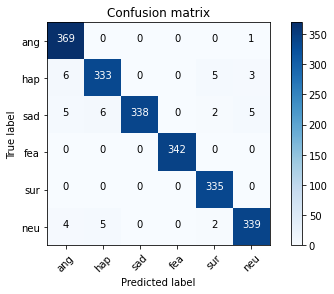

In [32]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=6, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree')
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.724
Test Set F-score =  0.707
Test Set Precision =  0.704
Test Set Recall =  0.721
Confusion matrix, without normalization
[[119   4   2   0   2   3]
 [ 26  71  19   0  11  26]
 [ 14  20  64   1   3  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  23  33   0   9  75]]


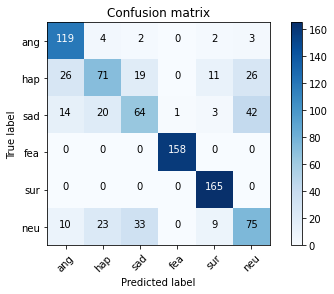

In [33]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.941
Test Set F-score =  0.942
Test Set Precision =  0.944
Test Set Recall =  0.942
Confusion matrix, without normalization
[[363   5   0   0   0   2]
 [ 24 307   0   0   9   7]
 [ 18  15 305   0   4  14]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  5  10   8   0   2 325]]


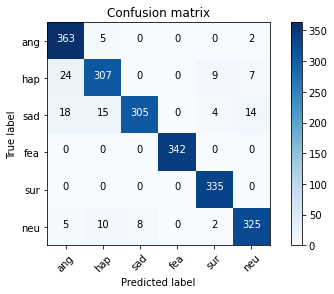

In [34]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.713
Test Set F-score =  0.694
Test Set Precision =  0.692
Test Set Recall =  0.708
Confusion matrix, without normalization
[[114  10   2   0   2   2]
 [ 30  68  16   0  11  28]
 [ 19  21  57   1   4  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  19  31   0  10  80]]


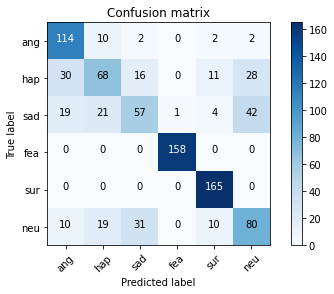

In [35]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.871
Test Set F-score =  0.870
Test Set Precision =  0.875
Test Set Recall =  0.872
Confusion matrix, without normalization
[[350   9   0   0   2   9]
 [ 42 263   7   1  16  18]
 [ 35  28 252   1   7  33]
 [  0   0   0 342   0   0]
 [  0   0   0   0 330   5]
 [ 12  20  20   0   6 292]]


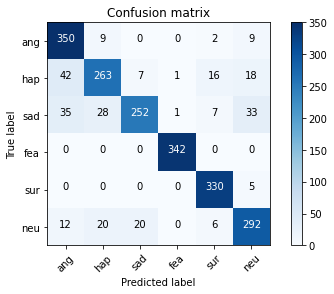

In [36]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=4, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.673
Test Set F-score =  0.652
Test Set Precision =  0.651
Test Set Recall =  0.667
Confusion matrix, without normalization
[[100  14   2   0   5   9]
 [ 34  59  14   0  20  26]
 [ 19  22  55   2   8  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 161   4]
 [ 15  20  31   0  11  73]]


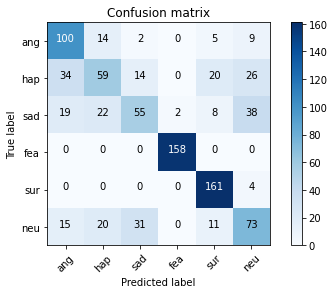

In [37]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

[12:08:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.995
Test Set F-score =  0.995
Test Set Precision =  0.995
Test Set Recall =  0.995
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  3 343   0   0   1   0]
 [  1   0 352   0   1   2]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  1   1   0   0   1 347]]


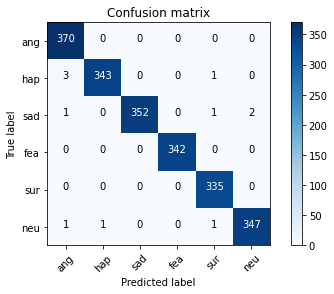

In [39]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.729
Test Set F-score =  0.712
Test Set Precision =  0.708
Test Set Recall =  0.725
Confusion matrix, without normalization
[[118   6   4   0   2   0]
 [ 23  78  19   0  10  23]
 [ 15  27  62   1   2  37]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  24  33   0   8  75]]


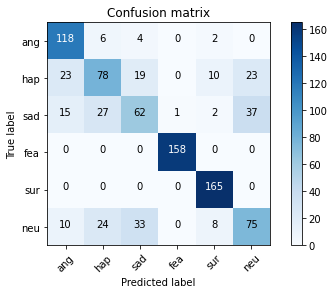

In [40]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:08:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   1   0   0   0 349]]


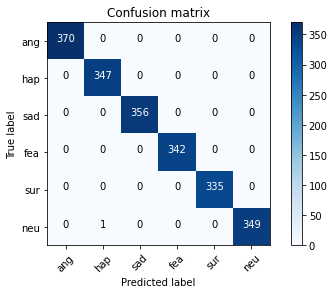

In [41]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=8, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.722
Test Set F-score =  0.706
Test Set Precision =  0.702
Test Set Recall =  0.718
Confusion matrix, without normalization
[[116   8   2   0   2   2]
 [ 24  77  18   0   9  25]
 [ 12  29  64   1   2  36]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  29  33   0   6  70]]


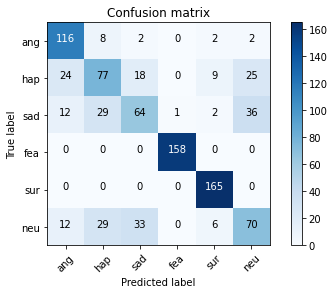

In [42]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:09:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


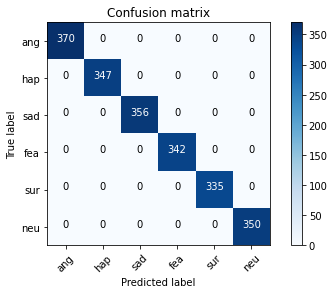

In [43]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=9, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.724
Test Set F-score =  0.709
Test Set Precision =  0.704
Test Set Recall =  0.720
Confusion matrix, without normalization
[[118   6   4   0   2   0]
 [ 25  77  16   0   7  28]
 [ 15  22  61   1   2  43]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  24  40   0   3  73]]


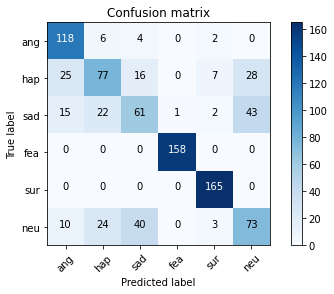

In [44]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:09:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


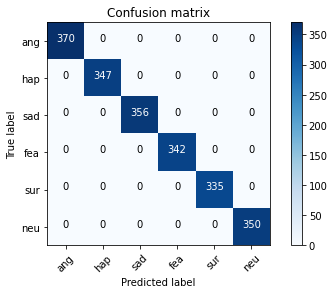

In [45]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.734
Test Set F-score =  0.719
Test Set Precision =  0.715
Test Set Recall =  0.730
Confusion matrix, without normalization
[[118   6   4   0   2   0]
 [ 27  78  17   0   8  23]
 [ 14  21  62   1   2  44]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  9  23  35   0   3  80]]


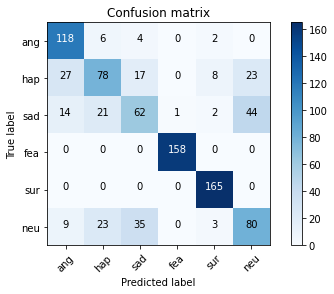

In [46]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


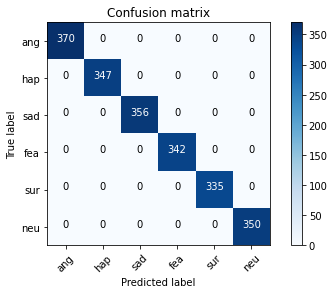

In [47]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=11, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.732
Test Set F-score =  0.716
Test Set Precision =  0.712
Test Set Recall =  0.728
Confusion matrix, without normalization
[[118   6   4   0   2   0]
 [ 25  82  17   0   8  21]
 [ 13  22  61   1   2  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  9  28  34   0   4  75]]


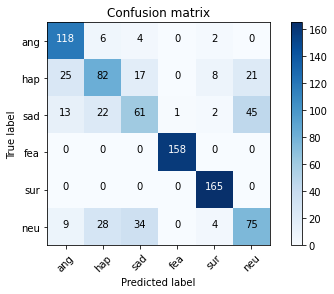

In [48]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:13:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


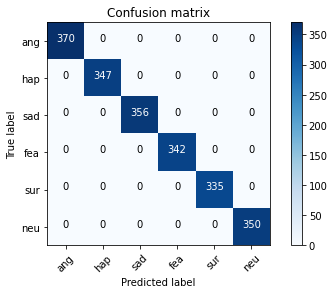

In [49]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=12, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.719
Test Set F-score =  0.703
Test Set Precision =  0.698
Test Set Recall =  0.714
Confusion matrix, without normalization
[[116   6   4   0   2   2]
 [ 24  73  20   0   9  27]
 [ 12  24  63   1   2  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 13  27  34   0   4  72]]


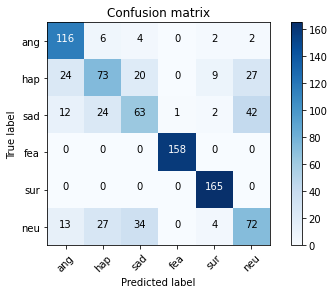

In [50]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:14:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


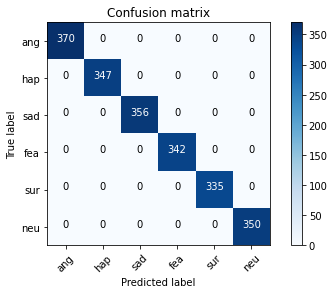

In [51]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=13, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.722
Test Set F-score =  0.706
Test Set Precision =  0.702
Test Set Recall =  0.718
Confusion matrix, without normalization
[[116   8   4   0   2   0]
 [ 24  73  21   0   9  26]
 [ 14  22  63   1   2  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  24  35   0   4  75]]


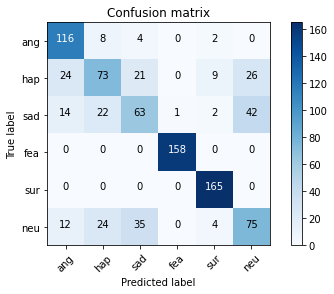

In [52]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.176
Test Set F-score =  0.050
Test Set Precision =  0.029
Test Set Recall =  0.167
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [347   0   0   0   0   0]
 [356   0   0   0   0   0]
 [342   0   0   0   0   0]
 [335   0   0   0   0   0]
 [350   0   0   0   0   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


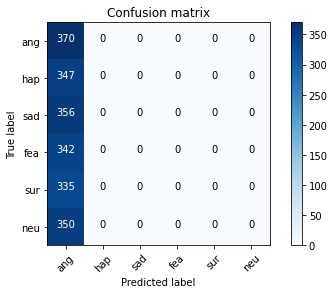

In [53]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.144
Test Set F-score =  0.042
Test Set Precision =  0.024
Test Set Recall =  0.167


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[130   0   0   0   0   0]
 [153   0   0   0   0   0]
 [144   0   0   0   0   0]
 [158   0   0   0   0   0]
 [165   0   0   0   0   0]
 [150   0   0   0   0   0]]


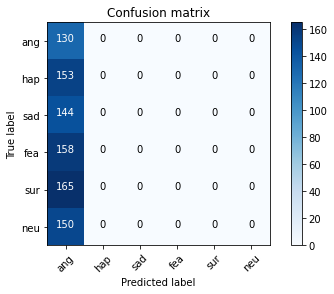

In [54]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.956
Test Set F-score =  0.956
Test Set Precision =  0.957
Test Set Recall =  0.956
Confusion matrix, without normalization
[[365   3   1   0   1   0]
 [ 12 310   2   1  11  11]
 [  6   5 334   0   3   8]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  5   4  14   0   5 322]]


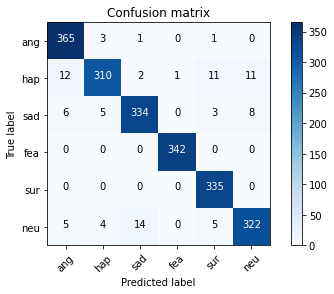

In [55]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.001, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.670
Test Set F-score =  0.648
Test Set Precision =  0.641
Test Set Recall =  0.666
Confusion matrix, without normalization
[[112  10   3   0   3   2]
 [ 27  44  29   1  12  40]
 [ 14  20  62   0   3  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  28  41   0   7  62]]


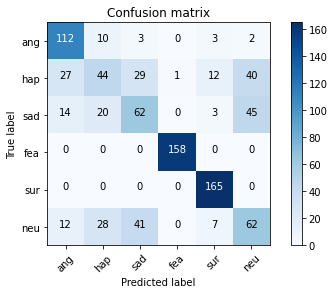

In [56]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.992
Test Set F-score =  0.992
Test Set Precision =  0.992
Test Set Recall =  0.992
Confusion matrix, without normalization
[[368   1   1   0   0   0]
 [  1 342   0   0   2   2]
 [  0   4 350   0   2   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   2   1   0   1 346]]


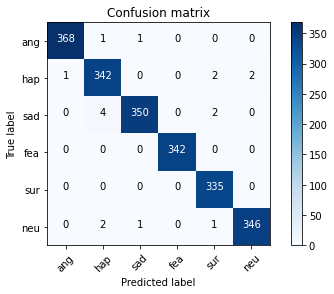

In [57]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.005, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.700
Test Set F-score =  0.681
Test Set Precision =  0.676
Test Set Recall =  0.696
Confusion matrix, without normalization
[[117   7   4   0   2   0]
 [ 27  64  20   0  10  32]
 [ 13  22  58   1   4  46]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  32  31   1   6  68]]


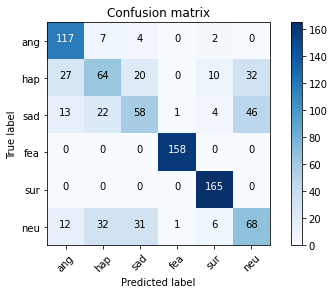

In [58]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.997
Test Set F-score =  0.997
Test Set Precision =  0.997
Test Set Recall =  0.997
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  1   1 353   0   1   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   2   1   0   0 347]]


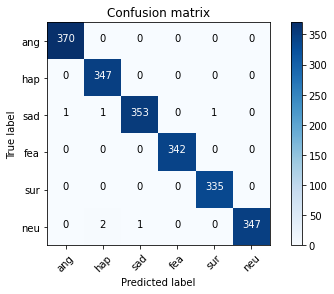

In [59]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.01, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.716
Test Set F-score =  0.698
Test Set Precision =  0.693
Test Set Recall =  0.711
Confusion matrix, without normalization
[[118   8   2   0   2   0]
 [ 22  73  23   0   8  27]
 [ 17  23  59   1   3  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 12  29  35   0   3  71]]


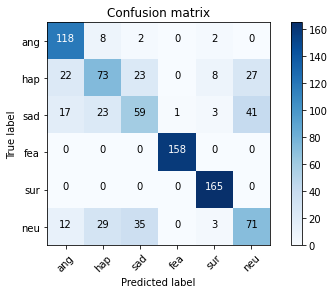

In [60]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


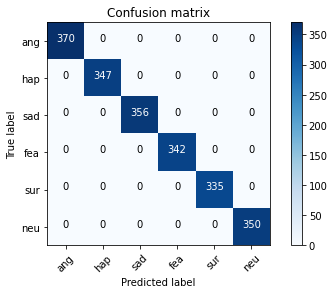

In [61]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.734
Test Set F-score =  0.719
Test Set Precision =  0.715
Test Set Recall =  0.730
Confusion matrix, without normalization
[[118   6   4   0   2   0]
 [ 27  78  17   0   8  23]
 [ 14  21  62   1   2  44]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  9  23  35   0   3  80]]


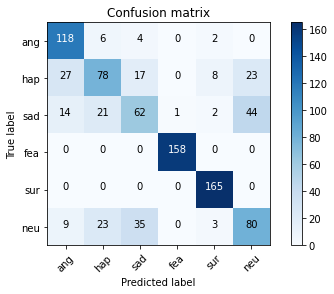

In [62]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


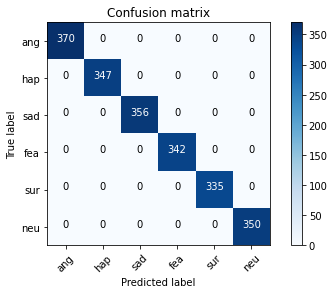

In [63]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.05, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.729
Test Set F-score =  0.714
Test Set Precision =  0.710
Test Set Recall =  0.724
Confusion matrix, without normalization
[[116   8   6   0   0   0]
 [ 23  81  19   0   5  25]
 [ 12  26  59   1   2  44]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  9  30  31   0   3  77]]


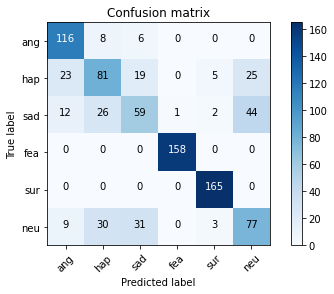

In [64]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


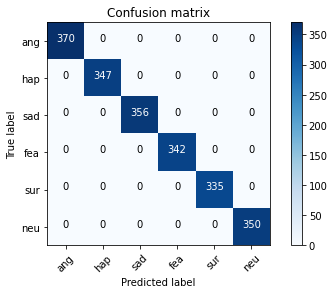

In [65]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.744
Test Set F-score =  0.732
Test Set Precision =  0.729
Test Set Recall =  0.740
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 21  79  23   0   5  25]
 [ 11  19  63   1   2  48]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  8  23  30   0   2  87]]


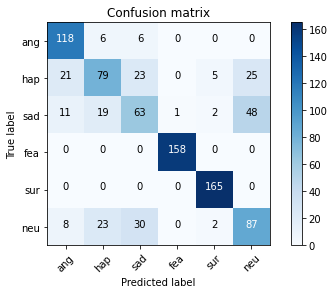

In [66]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


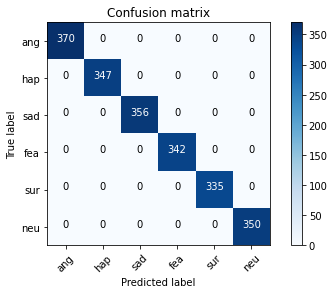

In [67]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.746
Test Set F-score =  0.734
Test Set Precision =  0.730
Test Set Recall =  0.742
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 21  74  24   0   7  27]
 [ 11  19  72   1   1  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  26  32   0   4  84]]


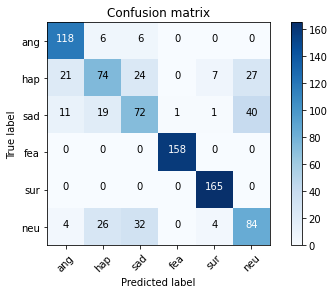

In [68]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


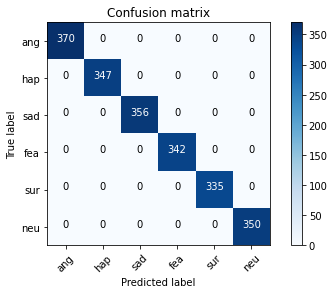

In [69]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.9, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.733
Test Set F-score =  0.720
Test Set Precision =  0.716
Test Set Recall =  0.730
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 19  71  19   0   8  36]
 [ 13  20  71   0   3  37]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  6  24  41   0   4  75]]


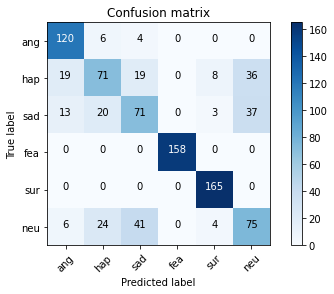

In [70]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:28:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


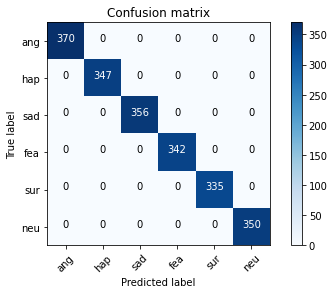

In [71]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=1, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.737
Test Set F-score =  0.723
Test Set Precision =  0.719
Test Set Recall =  0.734
Confusion matrix, without normalization
[[122   2   6   0   0   0]
 [ 17  73  21   0   8  34]
 [ 13  22  70   0   2  37]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 11  22  38   0   4  75]]


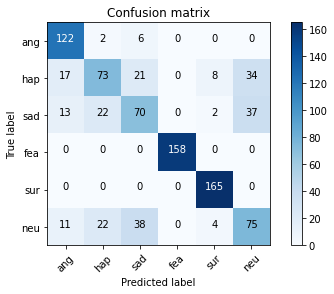

In [72]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:32:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


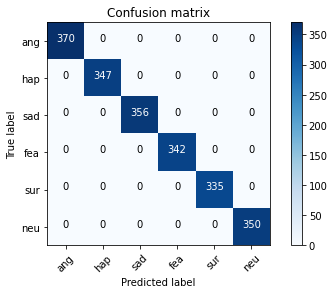

In [73]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=50, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.747
Test Set F-score =  0.735
Test Set Precision =  0.731
Test Set Recall =  0.743
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 17  74  26   0   9  27]
 [ 10  21  71   1   1  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  5  24  31   0   4  86]]


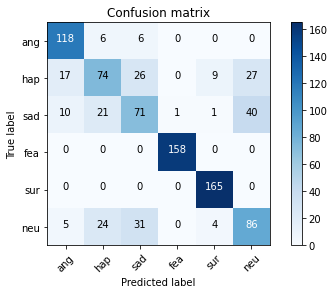

In [74]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:33:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


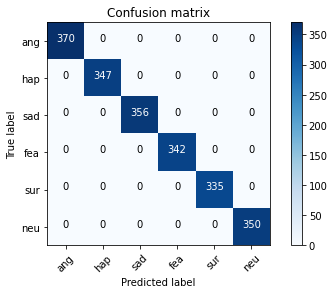

In [75]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.746
Test Set F-score =  0.734
Test Set Precision =  0.730
Test Set Recall =  0.742
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 21  74  24   0   7  27]
 [ 11  19  72   1   1  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  26  32   0   4  84]]


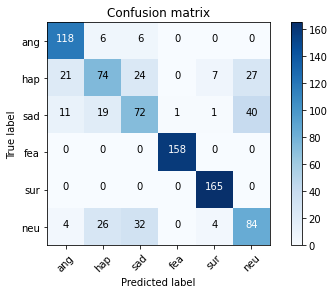

In [76]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:33:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


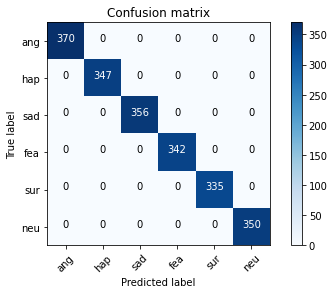

In [77]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.752
Test Set F-score =  0.740
Test Set Precision =  0.736
Test Set Recall =  0.749
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 22  75  23   0   8  25]
 [ 11  19  73   1   1  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  26  30   0   4  86]]


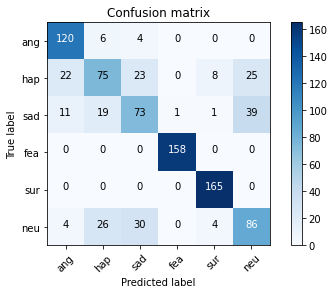

In [78]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


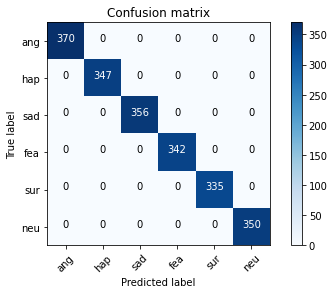

In [79]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=400, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.747
Test Set F-score =  0.734
Test Set Precision =  0.731
Test Set Recall =  0.743
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 22  73  22   0   6  30]
 [ 12  17  71   1   1  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  28  29   0   4  85]]


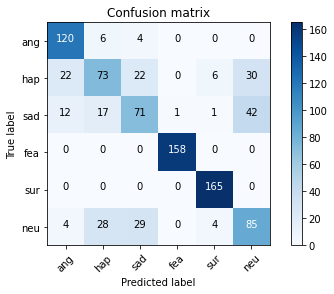

In [80]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:35:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


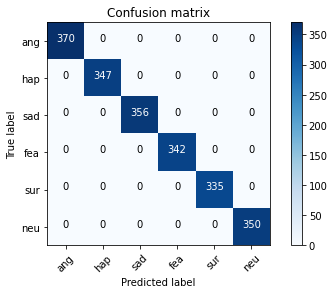

In [81]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=500, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.749
Test Set F-score =  0.736
Test Set Precision =  0.733
Test Set Recall =  0.746
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 21  73  23   0   8  28]
 [ 11  18  72   1   1  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  28  28   0   4  86]]


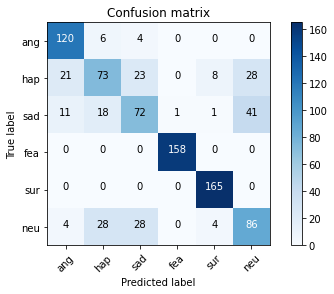

In [82]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


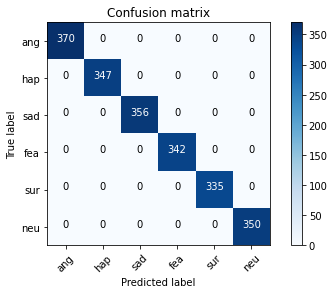

In [83]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=600, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.748
Test Set F-score =  0.735
Test Set Precision =  0.732
Test Set Recall =  0.744
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 21  73  22   0   8  29]
 [ 11  18  72   1   1  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  29  28   0   4  85]]


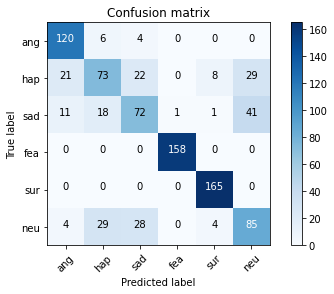

In [84]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


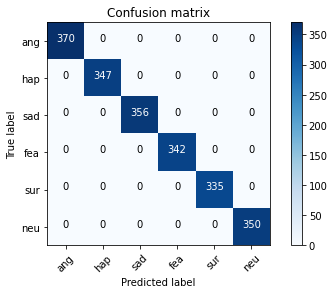

In [85]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=800, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.748
Test Set F-score =  0.735
Test Set Precision =  0.731
Test Set Recall =  0.744
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 21  73  22   0   8  29]
 [ 11  19  71   1   1  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  28  28   0   4  86]]


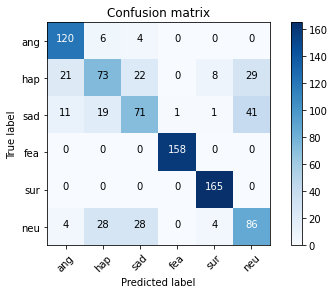

In [86]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:40:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


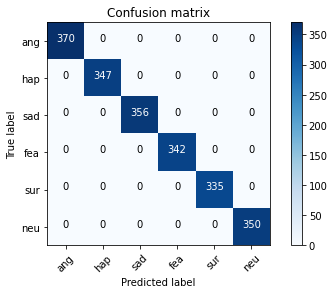

In [87]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=1000, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.747
Test Set F-score =  0.734
Test Set Precision =  0.730
Test Set Recall =  0.743
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 21  74  21   0   8  29]
 [ 11  18  71   1   2  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  29  29   0   4  84]]


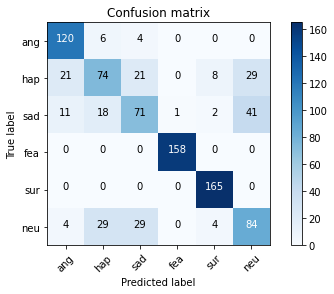

In [88]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:43:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


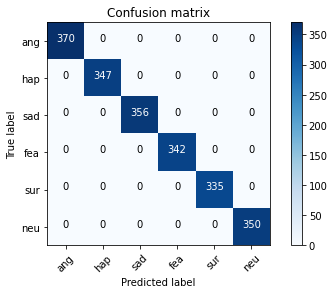

In [89]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=1200, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.748
Test Set F-score =  0.735
Test Set Precision =  0.731
Test Set Recall =  0.744
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 21  74  20   0   8  30]
 [ 11  18  72   1   2  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  29  29   0   4  84]]


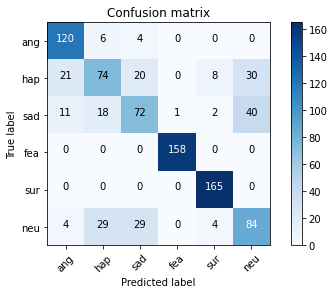

In [90]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:44:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


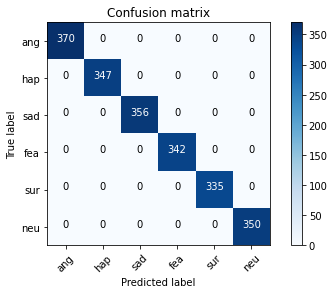

In [91]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=1500, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.746
Test Set F-score =  0.733
Test Set Precision =  0.729
Test Set Recall =  0.742
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 21  73  21   0   8  30]
 [ 10  19  71   1   2  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  29  29   0   4  84]]


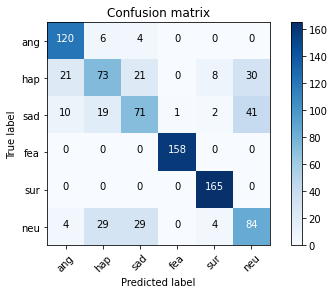

In [92]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:46:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


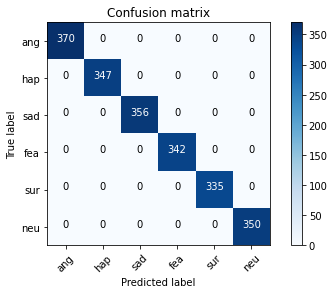

In [93]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=150, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.748
Test Set F-score =  0.735
Test Set Precision =  0.731
Test Set Recall =  0.745
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 23  73  23   0   7  27]
 [ 11  18  73   1   1  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  26  32   0   4  84]]


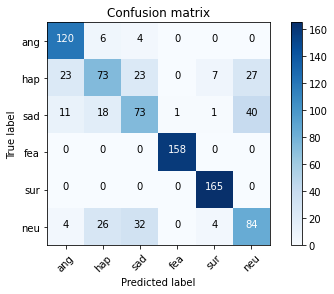

In [94]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:48:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


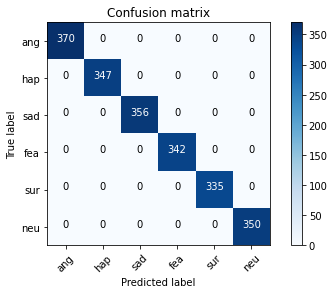

In [95]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=125, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.746
Test Set F-score =  0.734
Test Set Precision =  0.730
Test Set Recall =  0.742
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 23  73  24   0   6  27]
 [ 10  19  73   1   1  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  26  32   0   4  84]]


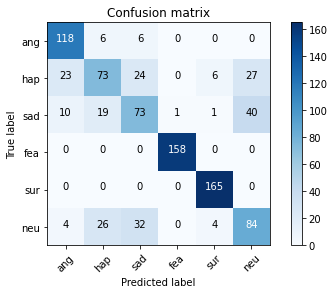

In [96]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

[12:57:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


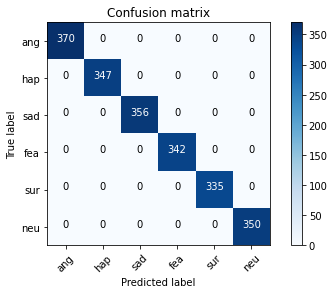

In [104]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.752
Test Set F-score =  0.740
Test Set Precision =  0.736
Test Set Recall =  0.749
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 22  75  23   0   8  25]
 [ 11  19  73   1   1  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  26  30   0   4  86]]


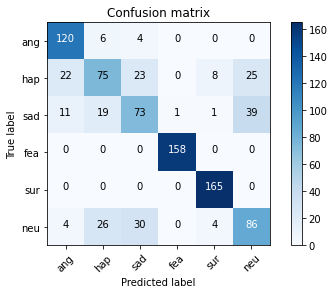

In [105]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


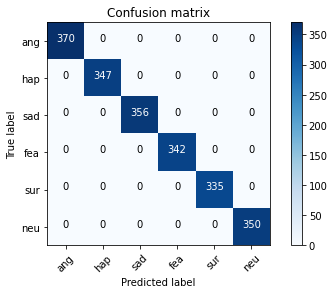

In [106]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=0.9, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.742
Test Set F-score =  0.729
Test Set Precision =  0.726
Test Set Recall =  0.738
Confusion matrix, without normalization
[[118   4   6   0   0   2]
 [ 21  74  21   0   7  30]
 [ 13  21  67   0   2  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 10  22  29   0   3  86]]


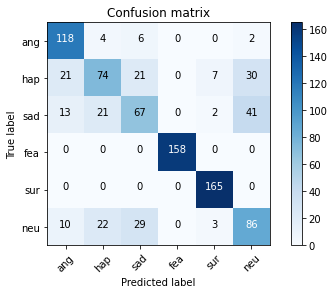

In [107]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


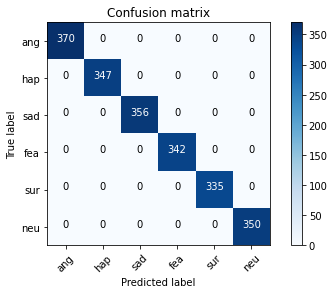

In [108]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.742
Test Set F-score =  0.729
Test Set Precision =  0.725
Test Set Recall =  0.738
Confusion matrix, without normalization
[[118   6   4   0   0   2]
 [ 25  73  22   0   7  26]
 [ 11  23  68   0   2  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  7  23  32   0   2  86]]


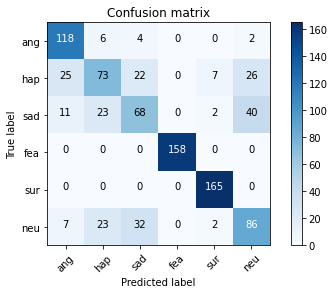

In [109]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


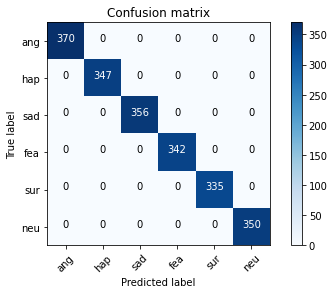

In [110]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=0.7, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.746
Test Set F-score =  0.734
Test Set Precision =  0.730
Test Set Recall =  0.741
Confusion matrix, without normalization
[[116  10   2   0   2   0]
 [ 24  75  20   0   4  30]
 [ 10  25  69   0   2  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  6  26  29   0   1  88]]


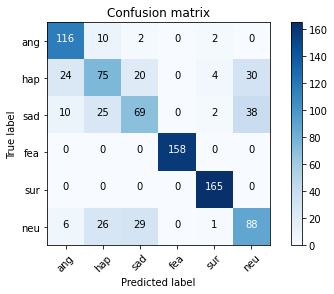

In [111]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


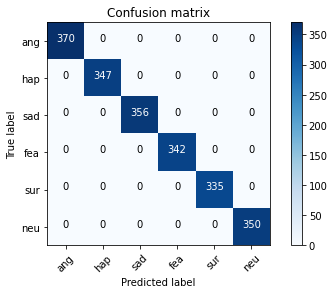

In [112]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=0.6, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.742
Test Set F-score =  0.731
Test Set Precision =  0.727
Test Set Recall =  0.738
Confusion matrix, without normalization
[[114  10   6   0   0   0]
 [ 23  77  20   0   7  26]
 [ 13  17  69   0   2  43]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  29  32   0   2  85]]


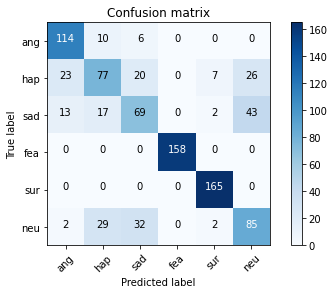

In [113]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


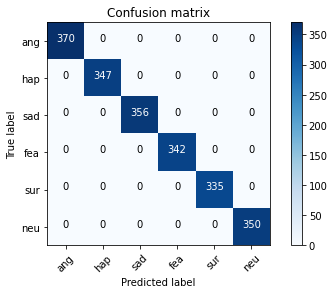

In [114]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=0.5, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.737
Test Set F-score =  0.725
Test Set Precision =  0.720
Test Set Recall =  0.733
Confusion matrix, without normalization
[[116   4  10   0   0   0]
 [ 20  71  23   0   7  32]
 [  8  26  71   2   1  36]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  6  22  35   0   5  82]]


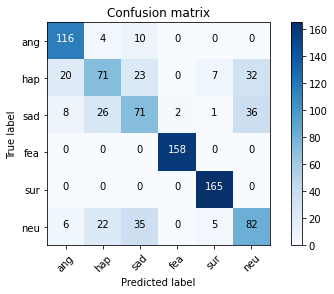

In [115]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


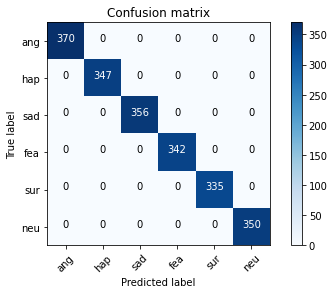

In [116]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.4, objective='multi:softprob', 
                                   n_estimators=125, subsample=0.4, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.741
Test Set F-score =  0.729
Test Set Precision =  0.726
Test Set Recall =  0.736
Confusion matrix, without normalization
[[114  10   6   0   0   0]
 [ 23  76  25   0   5  24]
 [ 15  21  67   0   0  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  6  22  33   0   2  87]]


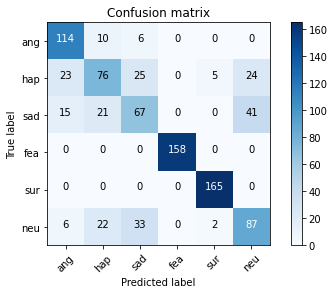

In [117]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:58:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


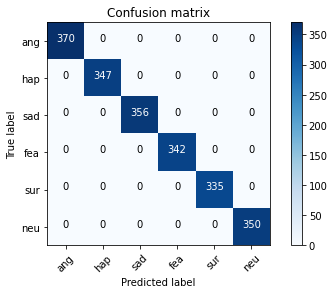

In [118]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=0.3, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.744
Test Set F-score =  0.732
Test Set Precision =  0.729
Test Set Recall =  0.741
Confusion matrix, without normalization
[[118   6   4   0   0   2]
 [ 21  74  22   0   9  27]
 [ 10  21  74   0   1  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  7  19  39   0   4  81]]


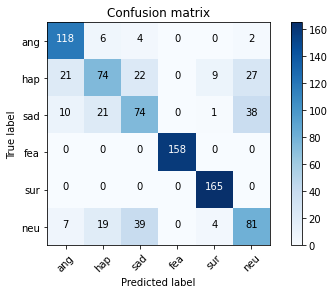

In [119]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:59:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


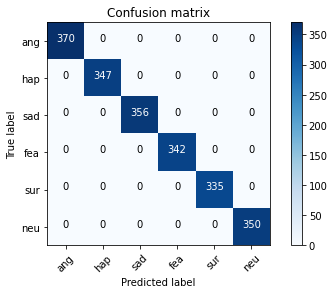

In [120]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=0.2, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.724
Test Set F-score =  0.711
Test Set Precision =  0.707
Test Set Recall =  0.721
Confusion matrix, without normalization
[[116   8   4   0   2   0]
 [ 22  69  32   0   6  24]
 [ 11  20  71   0   1  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  8  26  38   0   5  73]]


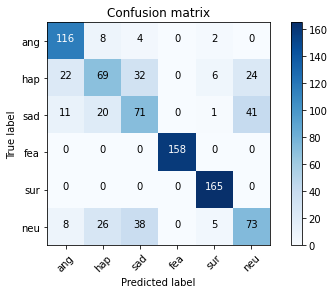

In [121]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:59:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.989
Test Set F-score =  0.989
Test Set Precision =  0.989
Test Set Recall =  0.989
Confusion matrix, without normalization
[[368   1   0   0   0   1]
 [  1 340   4   0   0   2]
 [  2   2 347   0   0   5]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  2   2   2   0   0 344]]


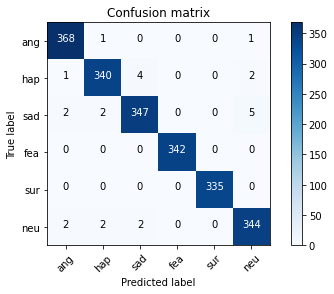

In [122]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=0.1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.713
Test Set F-score =  0.697
Test Set Precision =  0.694
Test Set Recall =  0.708
Confusion matrix, without normalization
[[110  11   4   0   2   3]
 [ 23  63  28   0   8  31]
 [ 14  19  67   0   5  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 16  21  30   0   4  79]]


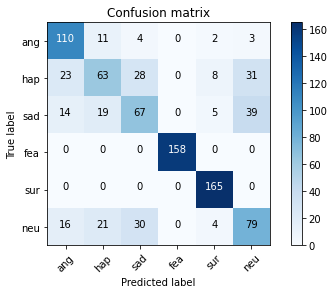

In [123]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:53] WARNING: ../src/learner.cc:576: 
Parameters: { "max_depth", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:01:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.581
Test Set F-score =  0.577
Test Set Precision =  0.577
Test Set Recall =  0.583
Confusion matrix, without normalization
[[225  42  26   6  44  27]
 [ 79 127  32   6  71  32]
 [ 47  30 176   3  41  59]
 [  0   0   0 342   0   0]
 [ 27  25  21   0 202  60]
 [ 24  39  75   4  59 149]]


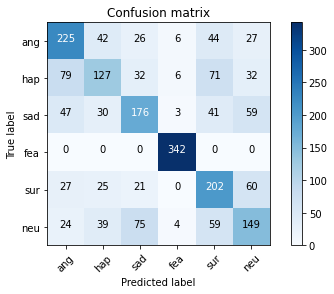

In [124]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=1, num_class=len(emotion_dict),
                                   booster='gblinear', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.562
Test Set F-score =  0.550
Test Set Precision =  0.545
Test Set Recall =  0.559
Confusion matrix, without normalization
[[ 77  22   6   2  13  10]
 [ 35  44  19   3  32  20]
 [ 14  15  71   1  12  31]
 [  0   0   0 158   0   0]
 [  7  17  21   0 101  19]
 [ 15  19  38   5  18  55]]


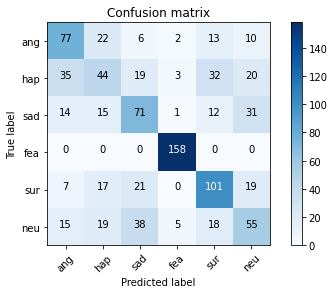

In [125]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


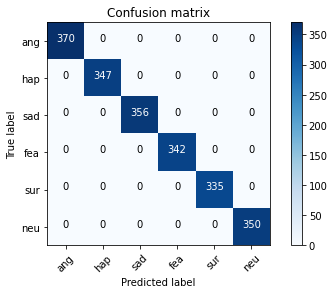

In [126]:
## XGB Classifier MFCC 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=200, subsample=1, num_class=len(emotion_dict),
                                   booster='dart', n_jobs=4)
xgb_classifier.fit(X_train_10_mfcc, y_train_10_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_10_mfcc)
display_results(y_train_10_mfcc, pred_probs)

6
Test Set Accuracy =  0.752
Test Set F-score =  0.740
Test Set Precision =  0.736
Test Set Recall =  0.749
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 22  75  23   0   8  25]
 [ 11  19  73   1   1  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  26  30   0   4  86]]


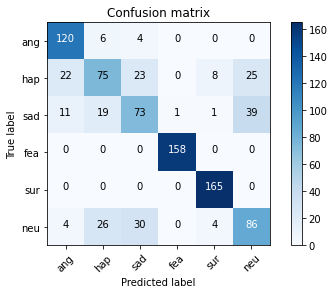

In [127]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mfcc)
display_results(y_test_10_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:10:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


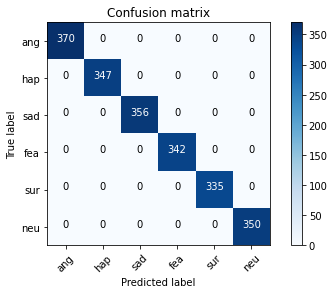

In [130]:
## XGB Classifier MFCC 30 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, subsample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=5)
xgb_classifier.fit(X_train_30_mfcc, y_train_30_mfcc)

pred_probs = xgb_classifier.predict_proba(X_train_30_mfcc)
display_results(y_train_30_mfcc, pred_probs)

6
Test Set Accuracy =  0.752
Test Set F-score =  0.741
Test Set Precision =  0.738
Test Set Recall =  0.748
Confusion matrix, without normalization
[[116  10   4   0   0   0]
 [ 20  84  18   0   6  25]
 [  9  24  65   0   1  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  26  29   0   2  89]]


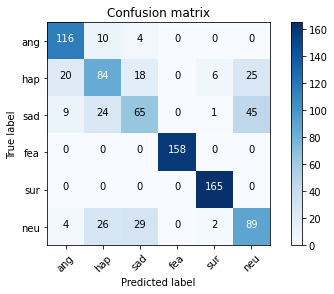

In [131]:
pred_probs = xgb_classifier.predict_proba(X_test_30_mfcc)
display_results(y_test_30_mfcc, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.882
Test Set F-score =  0.882
Test Set Precision =  0.888
Test Set Recall =  0.883
Confusion matrix, without normalization
[[348   3   6   1   0  12]
 [ 31 276   7   2   1  30]
 [ 40  25 255   3   1  32]
 [  0   0   0 342   0   0]
 [  4   0   3   0 328   0]
 [ 19  13  13   2   0 303]]


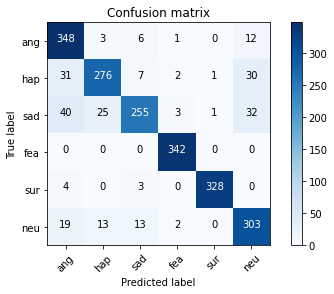

In [132]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=4, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.694
Test Set F-score =  0.677
Test Set Precision =  0.677
Test Set Recall =  0.690
Confusion matrix, without normalization
[[111   5   3   1   2   8]
 [ 37  66  19   2   3  26]
 [ 26  22  50   1   1  44]
 [  0   0   0 158   0   0]
 [  4   0   6   0 155   0]
 [  6  24  30   0   5  85]]


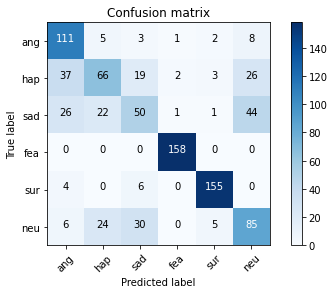

In [133]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.960
Test Set F-score =  0.960
Test Set Precision =  0.961
Test Set Recall =  0.960
Confusion matrix, without normalization
[[360   1   1   0   0   8]
 [  5 322   2   1   0  17]
 [ 20   4 324   0   0   8]
 [  0   0   0 342   0   0]
 [  0   3   0   0 332   0]
 [  4   6   4   1   0 335]]


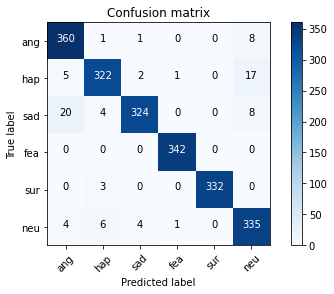

In [134]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.722
Test Set F-score =  0.705
Test Set Precision =  0.706
Test Set Recall =  0.718
Confusion matrix, without normalization
[[117   3   3   0   2   5]
 [ 36  69  16   2   5  25]
 [ 19  21  56   1   0  47]
 [  0   0   0 158   0   0]
 [  0   6   0   0 159   0]
 [  6  21  30   0   2  91]]


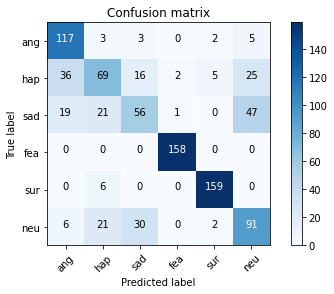

In [135]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:22:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.994
Test Set F-score =  0.994
Test Set Precision =  0.994
Test Set Recall =  0.994
Confusion matrix, without normalization
[[368   0   0   0   0   2]
 [  0 341   0   0   0   6]
 [  3   1 352   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   1   0   0   0 349]]


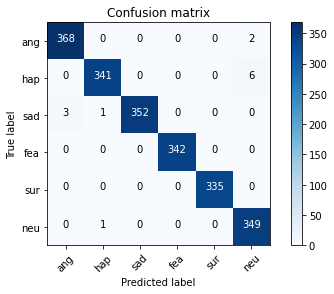

In [136]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=6, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.744
Test Set F-score =  0.728
Test Set Precision =  0.729
Test Set Recall =  0.740
Confusion matrix, without normalization
[[118   2   6   0   2   2]
 [ 32  73  22   1   4  21]
 [ 17  21  62   0   0  44]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  9  16  27   0   4  94]]


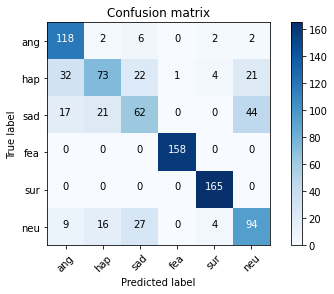

In [137]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


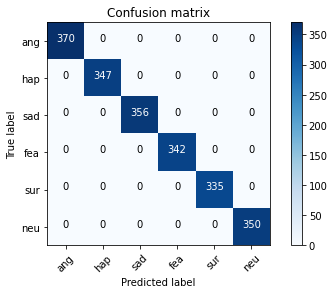

In [138]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.741
Test Set F-score =  0.726
Test Set Precision =  0.722
Test Set Recall =  0.737
Confusion matrix, without normalization
[[116   6   6   0   2   0]
 [ 27  68  30   2   5  21]
 [ 15  27  64   1   0  37]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  5  16  28   0   5  96]]


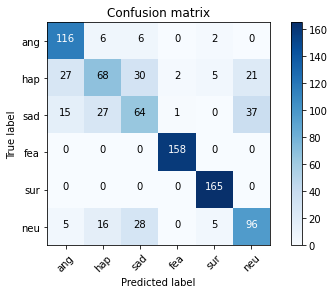

In [139]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


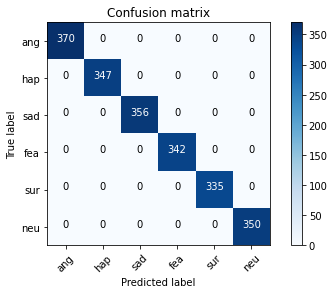

In [140]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=8, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.711
Test Set F-score =  0.694
Test Set Precision =  0.690
Test Set Recall =  0.706
Confusion matrix, without normalization
[[112   6   8   0   2   2]
 [ 31  66  29   2   3  22]
 [ 17  25  51   1   0  50]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  21  35   0   2  88]]


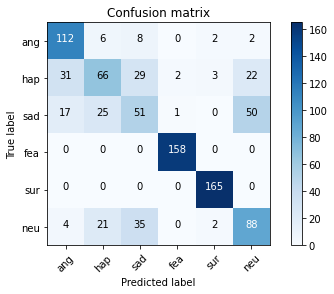

In [141]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


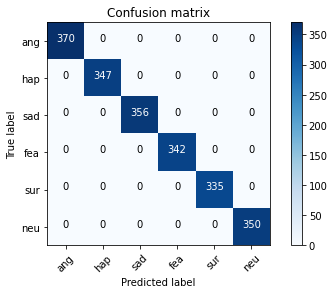

In [142]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=9, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.719
Test Set F-score =  0.704
Test Set Precision =  0.700
Test Set Recall =  0.713
Confusion matrix, without normalization
[[112   8   6   0   2   2]
 [ 27  68  27   2   3  26]
 [ 15  24  54   1   0  50]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  19  37   0   2  90]]


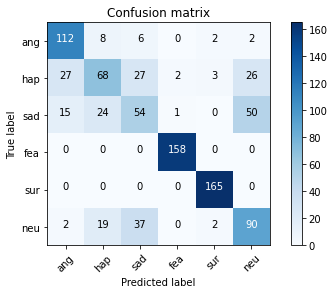

In [143]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:25:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


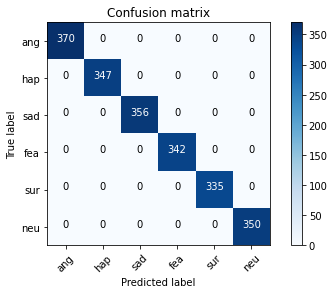

In [144]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=10, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.728
Test Set F-score =  0.713
Test Set Precision =  0.711
Test Set Recall =  0.723
Confusion matrix, without normalization
[[112   6   6   0   2   4]
 [ 26  70  28   2   3  24]
 [ 16  20  59   1   0  48]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  20  32   0   3  91]]


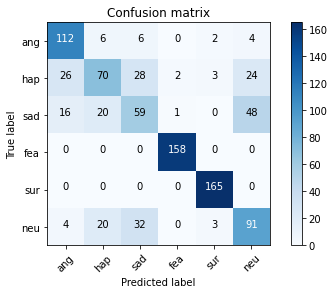

In [145]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:25:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


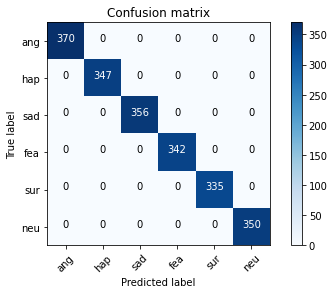

In [146]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=11, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.720
Test Set F-score =  0.705
Test Set Precision =  0.702
Test Set Recall =  0.715
Confusion matrix, without normalization
[[112   8   6   0   2   2]
 [ 25  72  28   2   2  24]
 [ 17  23  55   1   0  48]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  19  38   0   3  86]]


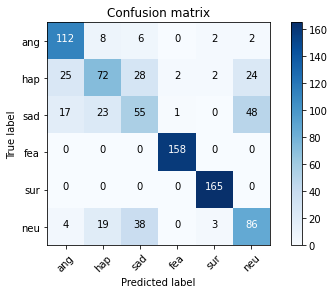

In [147]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


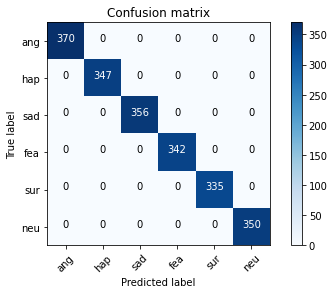

In [148]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=12, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.727
Test Set F-score =  0.711
Test Set Precision =  0.706
Test Set Recall =  0.722
Confusion matrix, without normalization
[[116   6   4   0   2   2]
 [ 26  72  28   2   3  22]
 [ 17  26  55   1   0  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  5  23  32   0   2  88]]


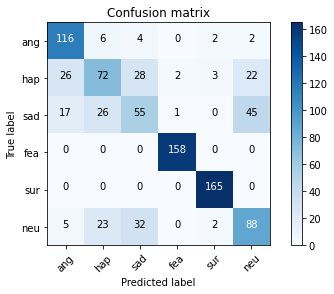

In [149]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


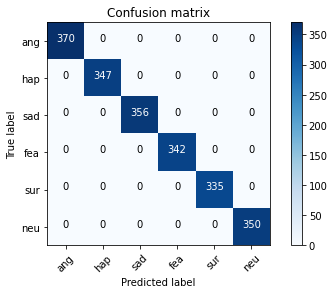

In [150]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=13, learning_rate=0.03, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.728
Test Set F-score =  0.713
Test Set Precision =  0.709
Test Set Recall =  0.722
Confusion matrix, without normalization
[[112   8   6   0   2   2]
 [ 23  75  24   2   3  26]
 [ 15  27  56   1   0  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  5  22  32   0   2  89]]


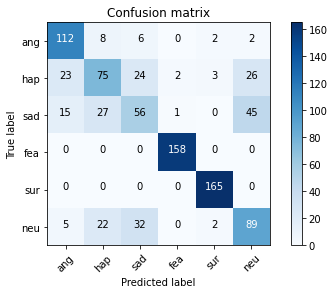

In [151]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.176
Test Set F-score =  0.050
Test Set Precision =  0.029
Test Set Recall =  0.167
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [347   0   0   0   0   0]
 [356   0   0   0   0   0]
 [342   0   0   0   0   0]
 [335   0   0   0   0   0]
 [350   0   0   0   0   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


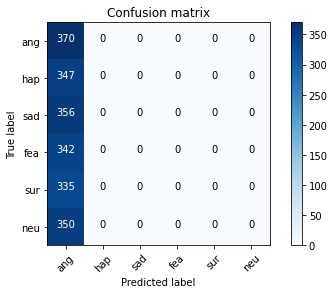

In [152]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.144
Test Set F-score =  0.042
Test Set Precision =  0.024
Test Set Recall =  0.167
Confusion matrix, without normalization
[[130   0   0   0   0   0]
 [153   0   0   0   0   0]
 [144   0   0   0   0   0]
 [158   0   0   0   0   0]
 [165   0   0   0   0   0]
 [150   0   0   0   0   0]]


/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


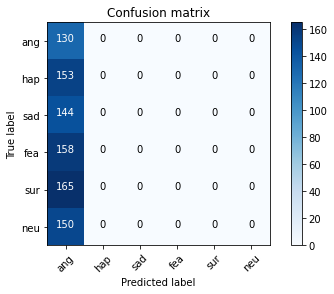

In [153]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:35:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.891
Test Set F-score =  0.891
Test Set Precision =  0.893
Test Set Recall =  0.892
Confusion matrix, without normalization
[[348   7   3   0   0  12]
 [ 20 287  17   1   5  17]
 [ 18  20 275   1   1  41]
 [  0   0   0 342   0   0]
 [  9   0   0   0 323   3]
 [ 12  18  17   0   7 296]]


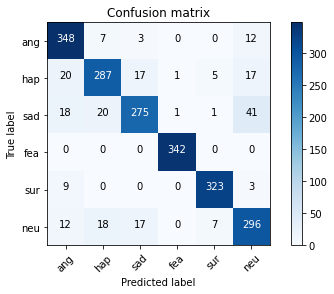

In [154]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.001, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.646
Test Set F-score =  0.629
Test Set Precision =  0.627
Test Set Recall =  0.639
Confusion matrix, without normalization
[[ 95  11   7   0   4  13]
 [ 29  59  27   2   8  28]
 [ 18  21  50   1   6  48]
 [  0   0   0 158   0   0]
 [  7   0   0   0 152   6]
 [ 10  25  41   0   7  67]]


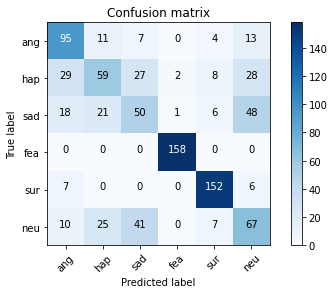

In [155]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:35:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.949
Test Set F-score =  0.950
Test Set Precision =  0.950
Test Set Recall =  0.949
Confusion matrix, without normalization
[[358   1   4   0   0   7]
 [  8 315   8   1   0  15]
 [ 13   9 320   0   0  14]
 [  0   0   0 342   0   0]
 [  4   0   0   0 331   0]
 [  6   7   7   0   3 327]]


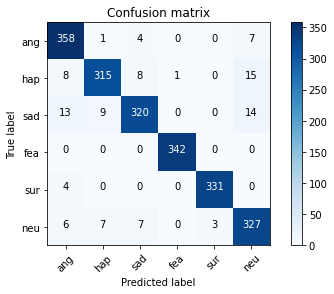

In [156]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.005, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.692
Test Set F-score =  0.674
Test Set Precision =  0.673
Test Set Recall =  0.686
Confusion matrix, without normalization
[[103   7   6   0   2  12]
 [ 33  59  26   2   6  27]
 [ 19  21  55   1   5  43]
 [  0   0   0 158   0   0]
 [  4   0   0   0 161   0]
 [  7  18  33   0   5  87]]


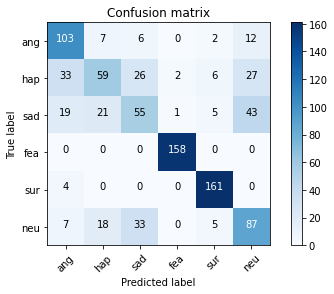

In [157]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:36:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.975
Test Set F-score =  0.975
Test Set Precision =  0.976
Test Set Recall =  0.975
Confusion matrix, without normalization
[[365   0   1   0   0   4]
 [  2 330   4   1   0  10]
 [  8   5 333   0   0  10]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  3   2   1   0   1 343]]


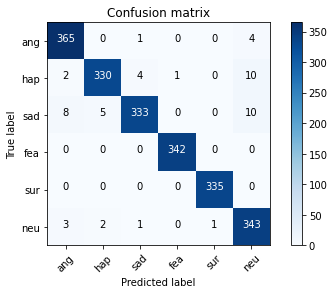

In [158]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.01, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.698
Test Set F-score =  0.678
Test Set Precision =  0.674
Test Set Recall =  0.692
Confusion matrix, without normalization
[[108   6   5   0   2   9]
 [ 31  60  27   2   5  28]
 [ 16  27  47   1   5  48]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  18  36   0   3  90]]


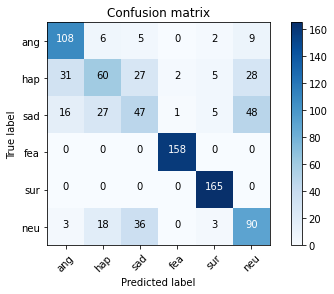

In [159]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


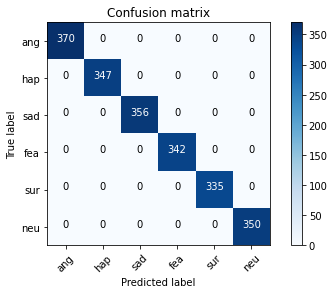

In [160]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.05, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.750
Test Set F-score =  0.737
Test Set Precision =  0.734
Test Set Recall =  0.746
Confusion matrix, without normalization
[[118   4   8   0   0   0]
 [ 20  77  27   2   5  22]
 [ 13  24  61   1   0  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  22  29   0   0  96]]


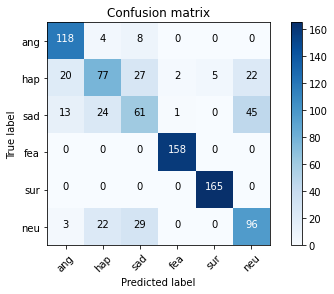

In [161]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


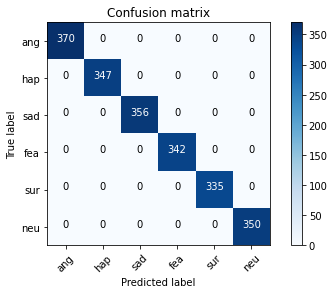

In [162]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.752
Test Set F-score =  0.739
Test Set Precision =  0.736
Test Set Recall =  0.748
Confusion matrix, without normalization
[[118   4   8   0   0   0]
 [ 22  81  25   1   3  21]
 [ 14  27  58   0   0  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  22  29   0   0  97]]


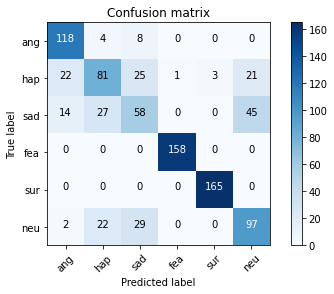

In [163]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:38:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


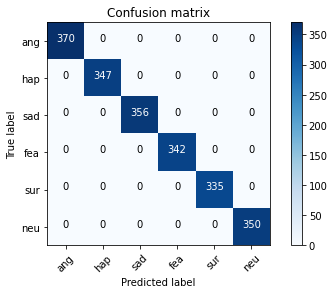

In [164]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.5, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.746
Test Set F-score =  0.735
Test Set Precision =  0.731
Test Set Recall =  0.741
Confusion matrix, without normalization
[[118   4   6   0   2   0]
 [ 19  81  26   1   1  25]
 [ 13  25  65   0   0  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  29  34   0   1  84]]


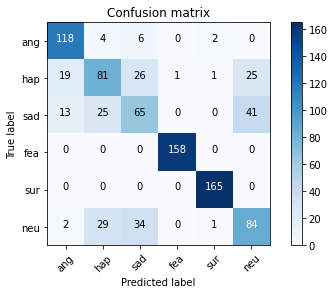

In [165]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:38:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


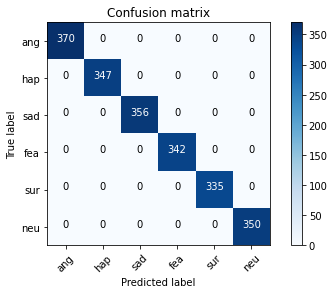

In [166]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.9, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.742
Test Set F-score =  0.733
Test Set Precision =  0.730
Test Set Recall =  0.738
Confusion matrix, without normalization
[[114   6   8   0   0   2]
 [ 18  80  27   1   3  24]
 [ 10  25  69   0   0  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  1  28  36   0   3  82]]


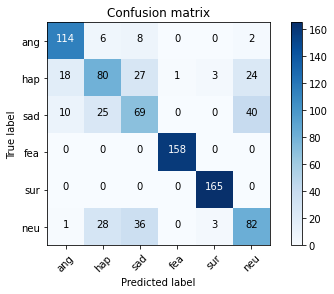

In [167]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


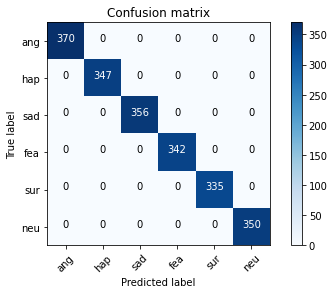

In [168]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=1, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.742
Test Set F-score =  0.732
Test Set Precision =  0.728
Test Set Recall =  0.738
Confusion matrix, without normalization
[[114   8   8   0   0   0]
 [ 19  83  24   1   0  26]
 [ 15  22  70   0   2  35]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  27  39   0   2  78]]


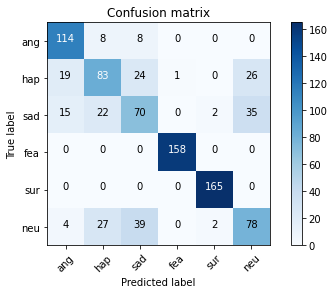

In [169]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:59:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


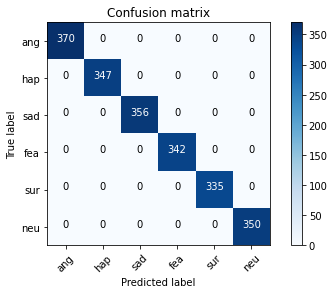

In [170]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=50, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.740
Test Set F-score =  0.726
Test Set Precision =  0.723
Test Set Recall =  0.735
Confusion matrix, without normalization
[[114   8   6   0   0   2]
 [ 29  71  21   2   5  25]
 [ 11  26  63   1   0  43]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  21  30   0   1  95]]


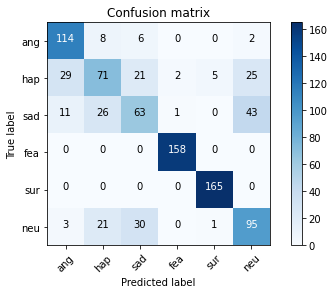

In [171]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:59:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


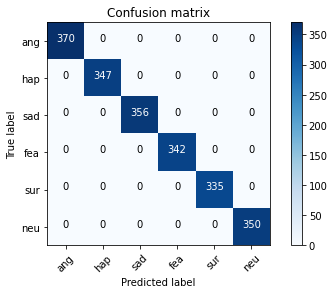

In [172]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=100, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.752
Test Set F-score =  0.739
Test Set Precision =  0.736
Test Set Recall =  0.748
Confusion matrix, without normalization
[[118   4   8   0   0   0]
 [ 22  81  25   1   3  21]
 [ 14  27  58   0   0  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  22  29   0   0  97]]


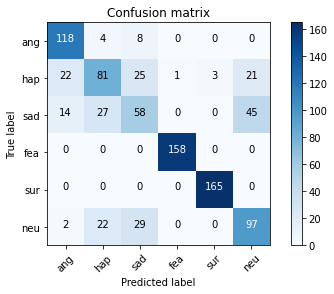

In [173]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


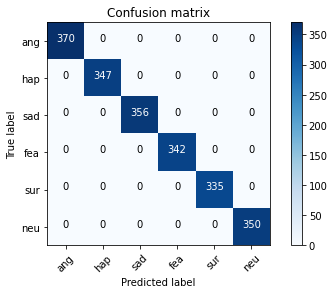

In [174]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=200, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.758
Test Set F-score =  0.747
Test Set Precision =  0.743
Test Set Recall =  0.753
Confusion matrix, without normalization
[[118   4   8   0   0   0]
 [ 22  86  24   1   1  19]
 [ 12  28  62   0   0  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  21  32   0   0  93]]


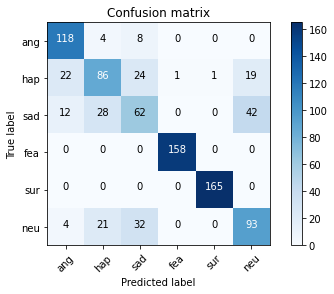

In [175]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


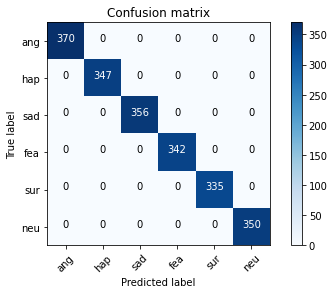

In [176]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.762
Test Set F-score =  0.751
Test Set Precision =  0.748
Test Set Recall =  0.758
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 22  87  23   1   2  18]
 [ 11  30  64   0   0  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  24  30   0   0  94]]


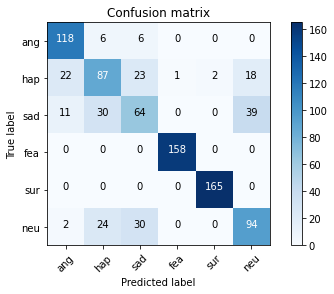

In [177]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:02:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


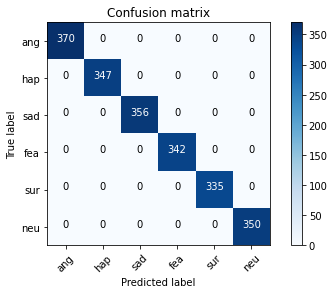

In [178]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=500, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.754
Test Set F-score =  0.744
Test Set Precision =  0.740
Test Set Recall =  0.750
Confusion matrix, without normalization
[[116   6   8   0   0   0]
 [ 22  88  20   1   2  20]
 [ 11  30  62   0   0  41]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  24  34   0   0  90]]


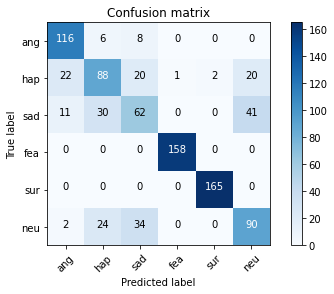

In [179]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


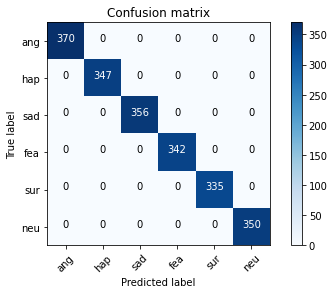

In [180]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=600, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.756
Test Set F-score =  0.745
Test Set Precision =  0.742
Test Set Recall =  0.751
Confusion matrix, without normalization
[[116   6   8   0   0   0]
 [ 22  87  20   1   2  21]
 [ 10  30  64   0   0  40]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  24  34   0   0  90]]


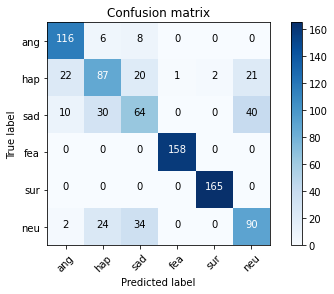

In [181]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:06:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


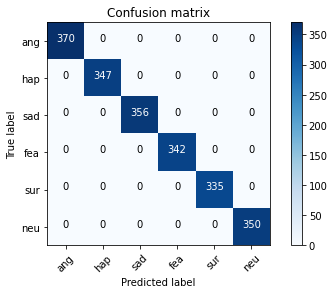

In [182]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=800, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.758
Test Set F-score =  0.747
Test Set Precision =  0.744
Test Set Recall =  0.753
Confusion matrix, without normalization
[[116   8   6   0   0   0]
 [ 22  87  19   1   3  21]
 [ 12  29  65   0   0  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  24  33   0   0  91]]


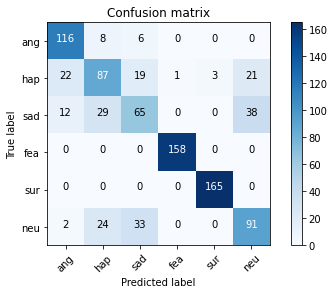

In [183]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:09:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


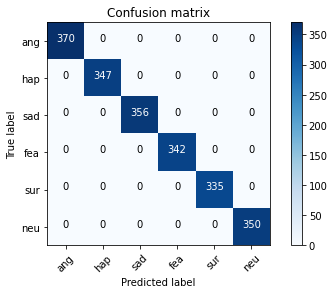

In [184]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=1000, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.757
Test Set F-score =  0.746
Test Set Precision =  0.743
Test Set Recall =  0.752
Confusion matrix, without normalization
[[116   8   6   0   0   0]
 [ 22  87  18   1   3  22]
 [ 10  30  66   0   0  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  25  33   0   0  89]]


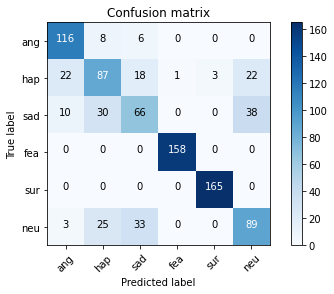

In [185]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:12:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


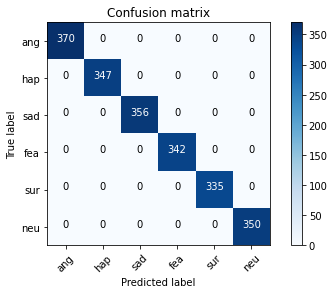

In [186]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=1200, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.751
Test Set F-score =  0.740
Test Set Precision =  0.737
Test Set Recall =  0.746
Confusion matrix, without normalization
[[114   8   8   0   0   0]
 [ 22  85  19   1   3  23]
 [ 12  28  65   0   0  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  25  33   0   0  89]]


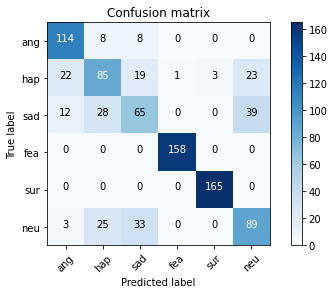

In [187]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:15:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


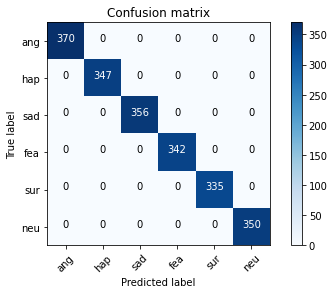

In [188]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=1500, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.752
Test Set F-score =  0.742
Test Set Precision =  0.739
Test Set Recall =  0.747
Confusion matrix, without normalization
[[114   8   8   0   0   0]
 [ 22  87  18   1   3  22]
 [ 12  28  65   0   0  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  28  32   0   0  88]]


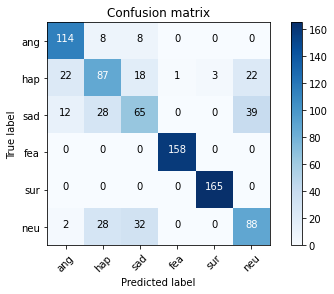

In [189]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:19:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


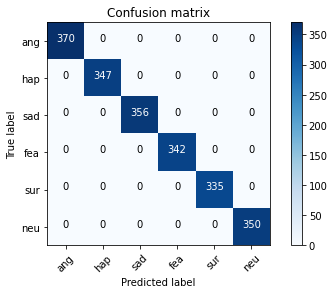

In [190]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=125, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.753
Test Set F-score =  0.742
Test Set Precision =  0.738
Test Set Recall =  0.749
Confusion matrix, without normalization
[[118   4   8   0   0   0]
 [ 22  84  25   1   2  19]
 [ 12  28  59   0   0  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  23  31   0   0  94]]


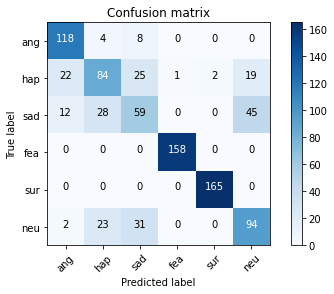

In [191]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


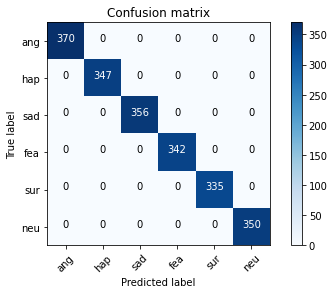

In [192]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=150, subsample=1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.754
Test Set F-score =  0.743
Test Set Precision =  0.739
Test Set Recall =  0.750
Confusion matrix, without normalization
[[118   4   8   0   0   0]
 [ 22  85  24   1   1  20]
 [ 12  29  59   0   0  44]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  21  31   0   0  94]]


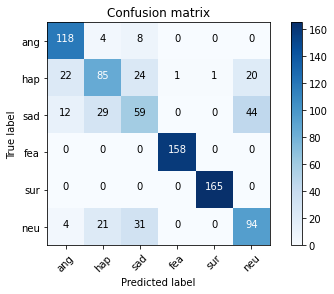

In [193]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


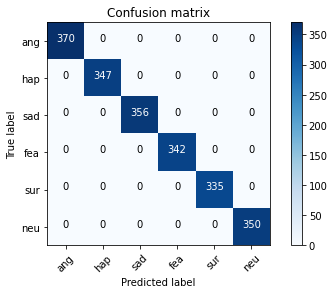

In [194]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.9, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.751
Test Set F-score =  0.739
Test Set Precision =  0.736
Test Set Recall =  0.747
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 25  77  24   1   3  23]
 [ 15  23  68   0   0  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  5  24  31   0   0  90]]


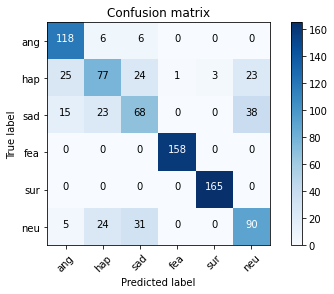

In [195]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


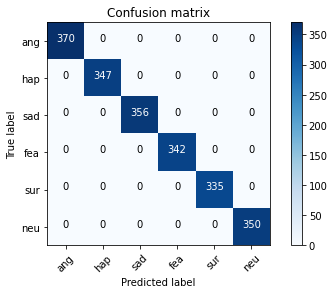

In [196]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.744
Test Set F-score =  0.733
Test Set Precision =  0.729
Test Set Recall =  0.740
Confusion matrix, without normalization
[[118   6   6   0   0   0]
 [ 27  81  18   1   3  23]
 [  8  26  65   0   0  45]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  6  28  33   0   0  83]]


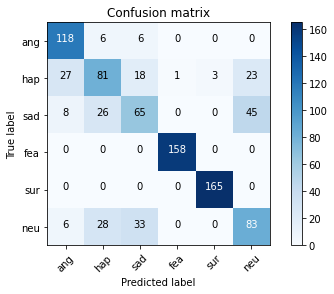

In [197]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


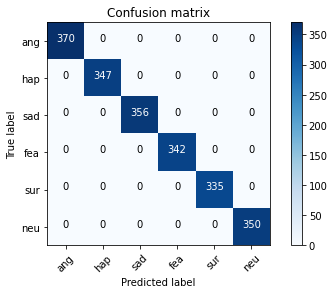

In [198]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.7, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.748
Test Set F-score =  0.737
Test Set Precision =  0.733
Test Set Recall =  0.744
Confusion matrix, without normalization
[[118   6   4   0   2   0]
 [ 23  79  21   0   3  27]
 [ 10  24  67   0   1  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  29  32   0   0  86]]


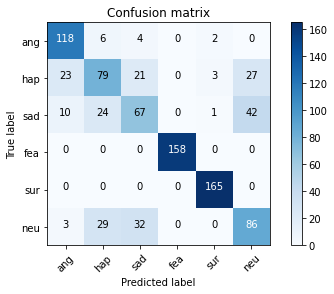

In [199]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:28:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


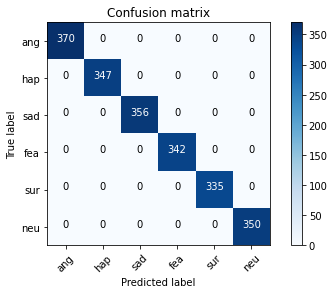

In [200]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.6, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.753
Test Set F-score =  0.743
Test Set Precision =  0.740
Test Set Recall =  0.749
Confusion matrix, without normalization
[[116   8   6   0   0   0]
 [ 27  81  20   0   2  23]
 [ 13  26  73   0   0  32]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  27  35   0   0  85]]


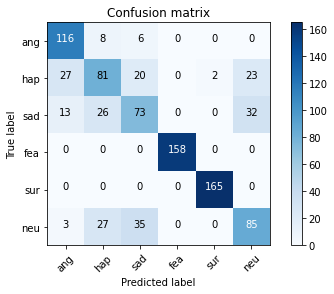

In [201]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


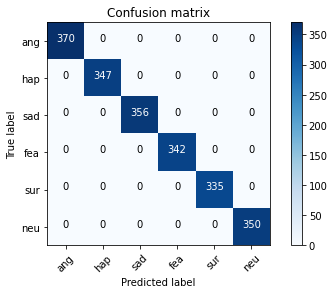

In [202]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.5, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.751
Test Set F-score =  0.741
Test Set Precision =  0.738
Test Set Recall =  0.747
Confusion matrix, without normalization
[[118  10   2   0   0   0]
 [ 21  81  22   0   2  27]
 [  8  29  68   0   1  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  25  35   0   0  86]]


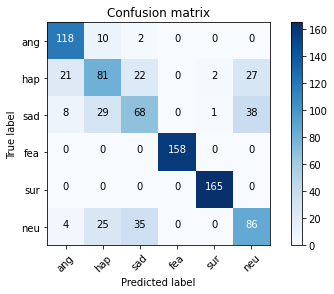

In [203]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

[15:41:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


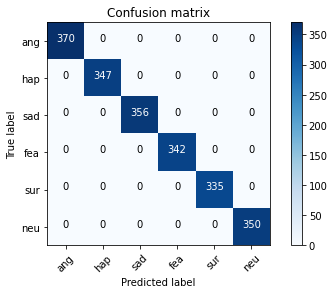

In [49]:
## Best XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.4, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.766
Test Set F-score =  0.756
Test Set Precision =  0.753
Test Set Recall =  0.762
Confusion matrix, without normalization
[[120   6   4   0   0   0]
 [ 19  88  22   0   4  20]
 [  9  26  73   0   0  36]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  4  24  37   0   0  85]]


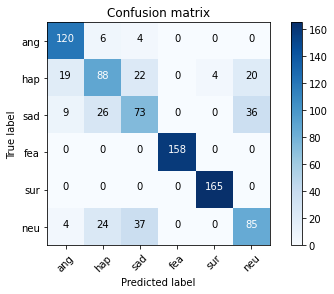

In [50]:
pred_probs_mel_10 = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs_mel_10)

In [51]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_10_mel.argmax(axis=1), pred_probs_mel_10.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.79      0.92      0.85       130
         hap       0.61      0.58      0.59       153
         sad       0.54      0.51      0.52       144
         fea       1.00      1.00      1.00       158
         sur       0.98      1.00      0.99       165
         neu       0.60      0.57      0.58       150

    accuracy                           0.77       900
   macro avg       0.75      0.76      0.76       900
weighted avg       0.76      0.77      0.76       900



In [52]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_10_mel.argmax(axis=1), pred_probs_mel_10.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_10_mel.argmax(axis=1), pred_probs_mel_10.argmax(axis=1))

len(correct_indices)

689

In [53]:
# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_test_10_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_10_mel.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_10_mel.argmax(axis=1)[i]))

In [54]:
dic_val_clipped = count_label(label_of_clipped_recognized)

dic_val_clipped

{'ang': 8, 'hap': 6, 'sad': 7, 'fea': 0, 'sur': 7, 'neu': 3}

<BarContainer object of 6 artists>

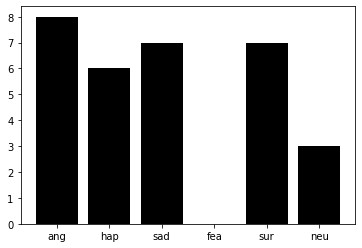

In [55]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [56]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)

clipped_ratio

0.775

In [57]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_test_10_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

len(indices_of_unclipped_recognized)

658

In [58]:
label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_10_mel.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_10_mel.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

<BarContainer object of 6 artists>

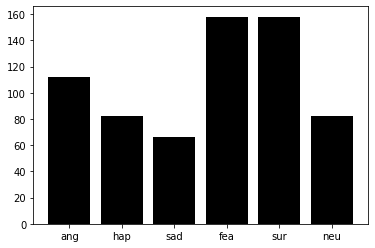

In [59]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [60]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)

unclipped_ratio

0.7651162790697674

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:52:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


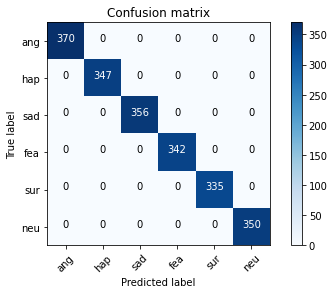

In [61]:
## Best XGB Classifier MEL 30 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.4, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_30_mel, y_train_30_mel)

pred_probs = xgb_classifier.predict_proba(X_train_30_mel)
display_results(y_train_30_mel, pred_probs)

6
Test Set Accuracy =  0.763
Test Set F-score =  0.753
Test Set Precision =  0.749
Test Set Recall =  0.760
Confusion matrix, without normalization
[[122   6   2   0   0   0]
 [ 25  82  24   0   2  20]
 [ 10  22  72   0   1  39]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  25  34   0   0  88]]


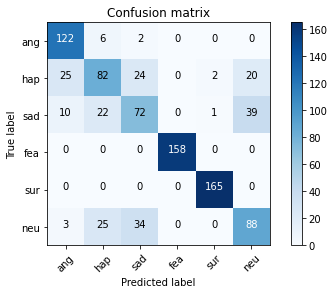

In [62]:
pred_probs_mel_30 = xgb_classifier.predict_proba(X_test_30_mel)
display_results(y_test_30_mel, pred_probs_mel_30)

In [63]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_30_mel.argmax(axis=1), pred_probs_mel_30.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.76      0.94      0.84       130
         hap       0.61      0.54      0.57       153
         sad       0.55      0.50      0.52       144
         fea       1.00      1.00      1.00       158
         sur       0.98      1.00      0.99       165
         neu       0.60      0.59      0.59       150

    accuracy                           0.76       900
   macro avg       0.75      0.76      0.75       900
weighted avg       0.76      0.76      0.76       900



/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


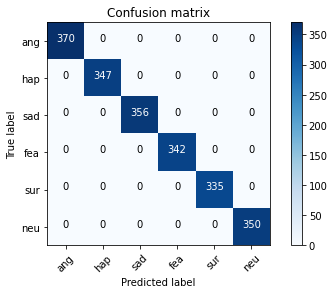

In [206]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.3, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.750
Test Set F-score =  0.739
Test Set Precision =  0.735
Test Set Recall =  0.746
Confusion matrix, without normalization
[[118   8   4   0   0   0]
 [ 23  78  22   0   6  24]
 [  9  27  70   0   0  38]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  5  21  37   0   1  86]]


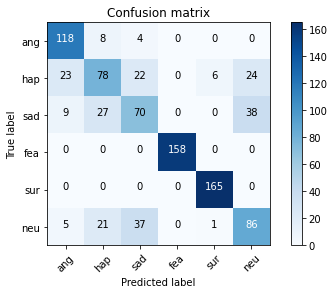

In [207]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


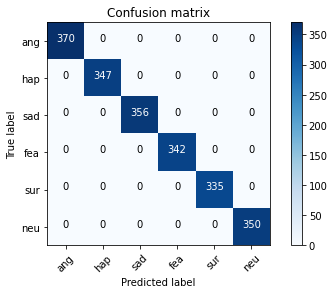

In [208]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.2, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.746
Test Set F-score =  0.736
Test Set Precision =  0.732
Test Set Recall =  0.741
Confusion matrix, without normalization
[[116   8   6   0   0   0]
 [ 21  83  24   1   2  22]
 [ 11  25  70   0   1  37]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  2  30  39   0   0  79]]


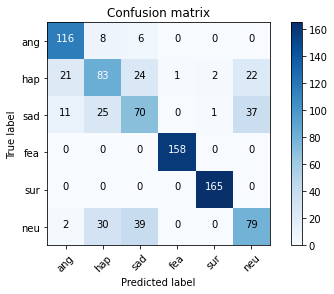

In [209]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:35:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.994
Test Set F-score =  0.994
Test Set Precision =  0.994
Test Set Recall =  0.994
Confusion matrix, without normalization
[[368   0   1   0   0   1]
 [  1 340   1   0   0   5]
 [  0   1 354   0   0   1]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   2   0   0 348]]


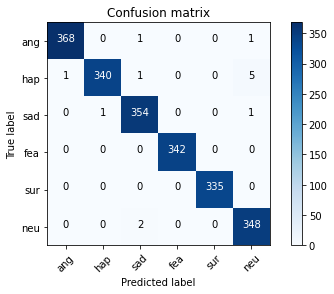

In [210]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.1, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.748
Test Set F-score =  0.739
Test Set Precision =  0.735
Test Set Recall =  0.744
Confusion matrix, without normalization
[[116  10   3   0   0   1]
 [ 20  80  23   0   4  26]
 [  9  30  74   0   0  31]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  3  29  38   0   0  80]]


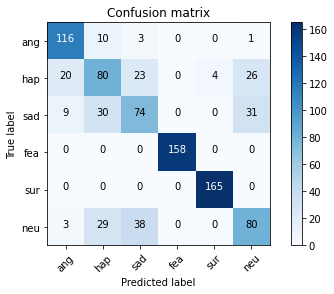

In [211]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:02] WARNING: ../src/learner.cc:576: 
Parameters: { "max_depth", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:40:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  0.660
Test Set F-score =  0.660
Test Set Precision =  0.661
Test Set Recall =  0.661
Confusion matrix, without normalization
[[256  43  24   0  30  17]
 [ 71 179  32   0  26  39]
 [ 42  32 180   0  22  80]
 [  0   0   0 342   0   0]
 [ 31  32  12   0 229  31]
 [ 27  32  62   1  28 200]]


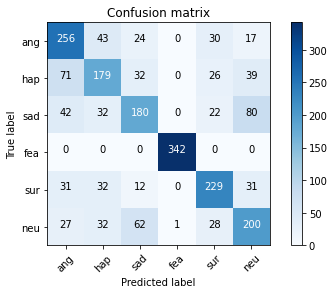

In [212]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.4, num_class=len(emotion_dict),
                                   booster='gblinear', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.611
Test Set F-score =  0.596
Test Set Precision =  0.592
Test Set Recall =  0.605
Confusion matrix, without normalization
[[ 86  16   7   2  11   8]
 [ 29  59  25   2  15  23]
 [ 19  23  53   2  13  34]
 [  0   0   0 158   0   0]
 [ 10  10   4   0 130  11]
 [ 10  13  41   2  20  64]]


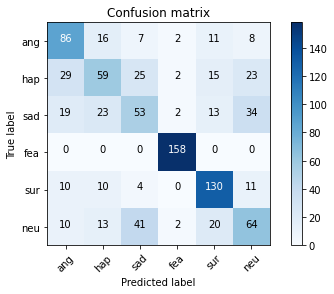

In [213]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)

/home/jupyter-reynaldo_delimajr/.local/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:55:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
Test Set Accuracy =  1.000
Test Set F-score =  1.000
Test Set Precision =  1.000
Test Set Recall =  1.000
Confusion matrix, without normalization
[[370   0   0   0   0   0]
 [  0 347   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 342   0   0]
 [  0   0   0   0 335   0]
 [  0   0   0   0   0 350]]


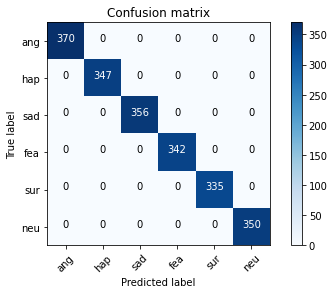

In [73]:
## XGB Classifier MEL 10 seconds
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, objective='multi:softprob', 
                                   n_estimators=400, subsample=0.4, num_class=len(emotion_dict),
                                   booster='dart', n_jobs=4)
xgb_classifier.fit(X_train_10_mel, y_train_10_mel)

pred_probs = xgb_classifier.predict_proba(X_train_10_mel)
display_results(y_train_10_mel, pred_probs)

6
Test Set Accuracy =  0.747
Test Set F-score =  0.735
Test Set Precision =  0.732
Test Set Recall =  0.742
Confusion matrix, without normalization
[[116   8   6   0   0   0]
 [ 26  81  21   0   4  21]
 [  9  26  67   0   0  42]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [  6  24  35   0   0  85]]


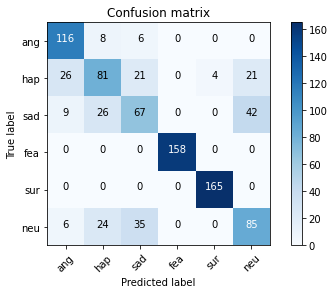

In [74]:
pred_probs = xgb_classifier.predict_proba(X_test_10_mel)
display_results(y_test_10_mel, pred_probs)